<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantum_tda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topological Data Analysis**

#### <font color="blue">***Classical (Financial) TDA***

###### *1) Libraries*

In [ ]:
import networkx as nx
import numpy as np
import string

import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.special import comb
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigs

from google.colab import files
import seaborn as sns

In [ ]:
# Libraries for Topological Data Analysis
!pip install -U giotto-tda --q                          # Complete TDA library from Giotto
from gtda.time_series import SingleTakensEmbedding      # Create Takens Embedding of Time Series
from gtda.plotting import plot_point_cloud              # Plot pointcloud from Takens Embedding in phase space
from gtda.diagrams import PersistenceLandscape          # Create persistence landscape from Takens Embedding
from gtda.diagrams import BettiCurve                    # Create Betti Curves
from gtda.homology import VietorisRipsPersistence       # Create persistence diagrams of the VietorisRips filtration
from gtda.homology import EuclideanCechPersistence      # Create persistence diagrams of the Čech filtration
from gtda.homology import WeightedRipsPersistence       # Create persistence diagrams of the Weighted (Vietoris–)Rips filtrations
from gtda.homology import WeakAlphaPersistence          # Create persistence diagrams of the Weak Alpha filtration
from gtda.homology import SparseRipsPersistence         # Create persistence diagrams of the SparseRips filtration
from gtda.diagrams import NumberOfPoints                # NumberOfPoints

###### *2) Functions*

In [ ]:
# implements Equation (54, now 55) in the notes
def resource_quantity(r, delta, E, betti, n, k, gap, cliques):
  ans = (math.pi * 0.5 * math.sqrt(comb(n, k) / cliques)) + (n * math.log((4 * cliques) / (r * betti)) / gap)
  ans *= 3 * E * math.log(1/delta) * math.sqrt(cliques / betti) / r
  return ans

In [ ]:
# Creates graph from the pairwise distance matrix for a given filtration
def pairwise_to_graph(pdist_matrix, filtration):
  n = pdist_matrix.shape[0]
  G = nx.Graph()
  for row in range(n):
    for column in range(n):
      if row < column:
        if pdist_matrix[row][column] < filtration:
          G.add_edge(row, column)
  return G

In [ ]:
# Calculates gap of a graph Laplacian
def get_gap(graph):
  laplacian = nx.laplacian_matrix(graph)
  laplacian = laplacian.toarray()
  eigvals = np.linalg.eigvals(laplacian)
  eigvals = np.unique(list(map(lambda x: 0 if x < 0.000000000001 else x, list(eigvals))))
  eigvals = np.sort(eigvals)
  return eigvals[1] - eigvals[0]

In [ ]:
# Counts the number of triangles in a graph
def number_of_triangles(graph):
  triangle_list = nx.triangles(graph).values()
  return sum(triangle_list)/3

In [ ]:
# Obtains the betti number from a birth-death diagram for a given filtration
def get_betti_from_diagram(birth_death_diagram, filtration, order):
  ans = 0
  for feature in birth_death_diagram[0]:
    if feature[0] <= filtration and feature[1] >= filtration and feature[2] == order:
      ans +=1
  return ans

In [ ]:
# returns the number of cliques of size size in the graph G
def get_number_of_cliques_of_size(G, size):
  if size == 3:
    return number_of_triangles(G)
  elif size == 2:
    return G.number_of_edges()
  elif size == 1:
    return G.number_of_nodes()
  else:
    print('Have not implemented this order yet.')
    return

In [ ]:
def get_delta_r_plot(pairwise_distances, diagram, order):
  #xs = np.linspace(0.00001, 0.5, num=100)
  xs = np.logspace(-5, 0, num=50)
  estimates_r = []
  estimates_delta = []
  r_xs = []
  delta_xs = []

  filtration = 0.0276

  for x in xs:
    graph = pairwise_to_graph(pairwise_distances, filtration)
    if nx.is_empty(graph):
      continue
    E = graph.number_of_edges()
    n = graph.number_of_nodes()
    gap = get_gap(graph)
    # print(gap)

    cliques = get_number_of_cliques_of_size(graph, order)

    betti = get_betti_from_diagram(diagram, filtration, order-1)
    if betti == 0:
      continue
    r_xs.append(x)
    estimates_r.append(resource_quantity(x, 0.01, E, betti , n, order, gap, cliques))

    delta_xs.append(x)
    estimates_delta.append(resource_quantity(0.01, x, E, betti , n, order, gap, cliques))
  print(estimates_delta)
  fig = plt.figure()
  ax_r = fig.add_subplot(121)
  ax_r.scatter(r_xs, estimates_r)
  ax_r.set_xlabel('r')
  ax_r.set_ylabel('number of Toffolis')
  ax_r.set_title('dependency on $r$')
  ax_r.set_yscale('log')
  ax_r.set_xscale('log')

  ax_delta = fig.add_subplot(122)
  ax_delta.scatter(delta_xs, estimates_delta)
  ax_delta.set_xlabel('delta')
  ax_delta.set_ylabel('number of Toffolis')
  ax_delta.set_title('dependency on $\delta$')
  ax_delta.set_yscale('log')
  ax_delta.set_xscale('log')

  fig.tight_layout()
  plt.savefig("r_delta_plots.pdf", dpi=150)
  plt.show()

In [ ]:
# plots the number of Toffolis versus the filtration for the given orders
def get_filtration_plot(pairwise_distances, diagram, orders, r, delta):
  longest_time = np.amax(diagram, axis=1)[0][1]
  shortest_time = np.amin(diagram, axis=1)[0][0]

  filtrations = np.linspace(2*shortest_time, longest_time, 100)
  filtrations = np.linspace(0.001, 0.1, 100)

  xs = [[] for i in range(len(orders))]
  estimates = [[] for i in range(len(orders))]

  for filtration in filtrations:
    graph = pairwise_to_graph(pairwise_distances, filtration)
    if nx.is_empty(graph):
      continue
    E = graph.number_of_edges()
    n = graph.number_of_nodes()
    gap = get_gap(graph)
    # print(gap)

    for ind, order in enumerate(orders):
      cliques = get_number_of_cliques_of_size(graph, order)

      betti = get_betti_from_diagram(diagram, filtration, order-1)
      if betti == 0:
        continue
      xs[ind].append(filtration)
      estimates[ind].append(resource_quantity(r, delta, E, betti , n, order, gap, cliques))

  for i in range(len(orders)):
    plt.scatter(xs[i], estimates[i], label=f'$k={orders[i]}$')
  plt.xlabel('filtration')
  plt.ylabel('number of Toffolis')
  plt.title('Resource estimates')
  plt.legend(loc='upper left')
  plt.savefig("estimate_vs_filtration.pdf", dpi=150)
  plt.show()

In [ ]:
# plots the gap of the Laplacian versus the filtration for the given orders
def get_gap_plot(pairwise_distances, diagram):
  longest_time = np.amax(diagram, axis=1)[0][1]
  shortest_time = np.amin(diagram, axis=1)[0][0]

  filtrations = np.linspace(2*shortest_time, longest_time, 100)
  filtrations = np.linspace(0.001, 0.1, 100)

  xs = []
  gaps = []

  for filtration in filtrations:
    graph = pairwise_to_graph(pairwise_distances, filtration)
    if nx.is_empty(graph):
      continue
    xs.append(filtration)
    gaps.append(get_gap(graph))

  plt.scatter(xs, gaps)
  plt.xlabel('filtration')
  plt.ylabel('Laplacian gap')
  plt.title('Gaps')
  plt.savefig("gap_plot.pdf", dpi=150)
  plt.show()

In [ ]:
# plots the number of Toffolis versus the system size for the given orders
def get_size_plot(pairwise_distances_list, diagram_list, orders, r, delta, filtration):
  assert len(pairwise_distances_list) == len(diagram_list), 'Diagram and pairwise distance lists have different sizes'

  xs = [[] for i in range(len(orders))]
  estimates = [[] for i in range(len(orders))]

  for i in range(len(diagram_list)):
      graph = pairwise_to_graph(pairwise_distances_list[i], filtration)
      if nx.is_empty(graph):
        continue
      print('not empty')
      E = graph.number_of_edges()
      n = graph.number_of_nodes()
      gap = get_gap(graph)

      for ind, order in enumerate(orders):
        cliques = get_number_of_cliques_of_size(graph, order)

        betti = get_betti_from_diagram(diagram_list[i], filtration, order-1)
        if betti == 0:
          continue
        print('not zero')
        xs[ind].append(n)
        estimates[ind].append(resource_quantity(r, delta, E, betti, n, order, gap, cliques))
  print(xs)
  print(estimates)
  for i in range(len(orders)):
    plt.scatter(xs[i], estimates[i], label=f'$k={orders[i]}$')
  plt.xlabel('n')
  plt.ylabel('number of Toffolis')
  plt.title('Resource estimates')
  plt.legend(loc='upper left')
  plt.show()

###### *3) Financial data going through the pipeline*

In [ ]:
# Import raw data and display table content
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/sp500c.csv'
data_raw = pd.read_csv(url)

# Rename imported time series
data = data_raw

# Select specific features, and rename features
data = data[['Date', 'Open', 'High', 'Low', 'Close']].rename(columns={"Date": "date", "Close": "price"})
data = data.drop(['Open', 'High', 'Low'], axis=1)

# Set date index
data = data.set_index('date')

# Add Frequency (business days)
data.index = pd.to_datetime(data.index, utc=True)
data = data.asfreq('B') # B stands for business day, so that weekends and bank holiday as non trading day are ignored

# Remove nan
data = data.dropna()

data_original = data # We will need this later to differentiate between preprocessed and original data

# Log Return
data = np.log(data/data.shift(1)).dropna()

# data = (data-data.mean())/data.std()            # Mean Normalization
data = (data-data.min())/(data.max()-data.min())  # Min Max Normalization
data = data.dropna()                              # remove nan value
#data.plot(title='S&P500: Logreturn & MinMax Normalized')

# Choose original or preprocessed data
series = data                                   # Choose "data" for logreturned series, or "data_original" for unprocessed series

series = series['2010-01-01':'2015-01-01']
series

,price
date,
2010-01-04 00:00:00+00:00,0.605201
2010-01-05 00:00:00+00:00,0.551221
2010-01-06 00:00:00+00:00,0.540407
2010-01-07 00:00:00+00:00,0.554941
2010-01-08 00:00:00+00:00,0.550238
...,...
2014-12-24 00:00:00+00:00,0.537521
2014-12-26 00:00:00+00:00,0.552036
2014-12-29 00:00:00+00:00,0.541739


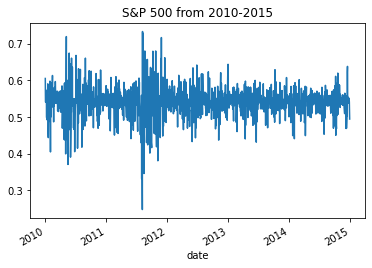

In [ ]:
#sns.set(rc={'figure.figsize':(8, 8), "lines.linewidth": 1.0})

plot = series.plot(title='S&P 500 from 2010-2015', legend=False)
fig = plot.get_figure()
#fig.savefig("s_and_p_after_preprocessing.pdf", dpi=300)
#files.download("s_and_p_after_preprocessing.pdf")

###### *4) TDA Output + Resource Estimation according to equation #55*

In [ ]:
# generates pairwise distances and birth-death diagram from series data
def process_data(series):
  # Hyperparameter for Takens Time Delay Embedding
  embedding_dimension = 3                         # Upper bound for optimal embedding dimension d determined by false nearest neighbours
  embedding_time_delay = 3                        # Upper bound for optimal time delay Tau determined by mutual information or ACF
  parameters_type = "search"                      # Get optimal value for embedding_dimension & embedding_time_delay. Otherwise: "fixed"
  stride = 8                                      # Increase stride to reduce amount of data
  n_jobs=-1                                       # Maximum number of jobs to use for the computation

  # Hyperparameter for Persistence Diagrams
  # filtration = VietorisRipsPersistence          # Choose the filtration method - we do that below separately
  homology_dimensions = [0, 1, 2, 3]                 # Persistence Diagrams with 0-connected components, 1-loops, 2-voids, and higher orders
  reduced_homology=True

  # Takens Embedding
  embedder = SingleTakensEmbedding(
      parameters_type=parameters_type,
      n_jobs=n_jobs,
      time_delay=embedding_time_delay,
      dimension=embedding_dimension,
      stride=stride,
  )

  y_embedded = embedder.fit_transform(series.price)
  #print('Optimal time delay based on mutual information:', embedder.time_delay_)
  #print('Optimal embedding dimension based on false nearest neighbors:', embedder.dimension_)
  #print(f"Shape of embedded time series: {y_embedded.shape}")

  pairwise_distances = squareform(pdist(y_embedded, metric='euclidean'))

  # plot_point_cloud(y_embedded)

  # Postprocessing embedding to transform matrix for filtration process
  y_embedded = y_embedded[None, :, :]

  # Filtration method for computing the persistence diagram
  filtration = VietorisRipsPersistence

  # Create Persistence Diagrams from Takens Time Delay Embedding
  persistence = filtration(
      homology_dimensions=homology_dimensions, n_jobs=6, reduced_homology=reduced_homology)
  print("Persistence Diagram")
  diagram = persistence.fit_transform_plot(y_embedded)

  return pairwise_distances, diagram

**Get Filtration Plot**

Persistence Diagram


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning:

Casting complex values to real discards the imaginary part



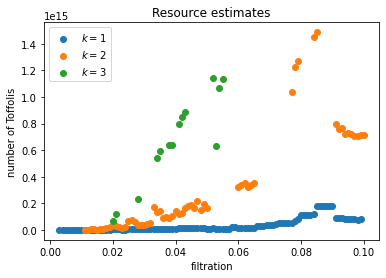

In [ ]:
pairwise_distances, diagram = process_data(series)
get_filtration_plot(pairwise_distances, diagram, [1, 2, 3], 0.0001, 0.0001)

**Get Delta R Plot**

Persistence Diagram


[(2289745182356.902+0j), (2243015688839.414+0j), (2196286195321.926+0j), (2149556701804.4385+0j), (2102827208286.9504+0j), (2056097714769.4622+0j), (2009368221251.975+0j), (1962638727734.487+0j), (1915909234216.999+0j), (1869179740699.5115+0j), (1822450247182.0234+0j), (1775720753664.536+0j), (1728991260147.048+0j), (1682261766629.5603+0j), (1635532273112.0723+0j), (1588802779594.5845+0j), (1542073286077.0967+0j), (1495343792559.6091+0j), (1448614299042.121+0j), (1401884805524.6335+0j), (1355155312007.1458+0j), (1308425818489.6582+0j), (1261696324972.1702+0j), (1214966831454.6824+0j), (1168237337937.1946+0j), (1121507844419.707+0j), (1074778350902.2192+0j), (1028048857384.7311+0j), (981319363867.2435+0j), (934589870349.7557+0j), (887860376832.2678+0j), (841130883314.7802+0j), (794401389797.2922+0j), (747671896279.8046+0j), (700942402762.3168+0j), (654212909244.8289+0j), (607483415727.3412+0j), (560753922209.8535+0j), (514024428692.36554+0j), (467294935174.87787+0j), (420565441657.3901+

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning:

Casting complex values to real discards the imaginary part



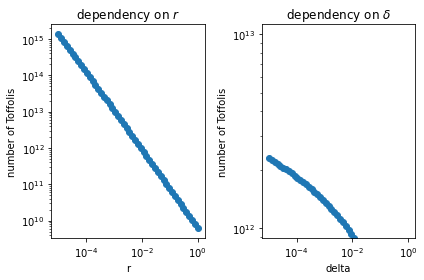

In [ ]:
pairwise_distances, diagram = process_data(series)
get_delta_r_plot(pairwise_distances, diagram, 3)

**Get Gap Plot**

Persistence Diagram


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning:

Casting complex values to real discards the imaginary part



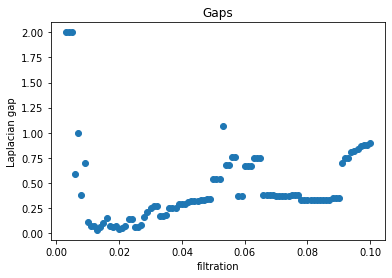

In [ ]:
pairwise_distances, diagram = process_data(series)
get_gap_plot(pairwise_distances, diagram)

**Get Size Plot**

In [ ]:
#pairwise_distances_list = []
#diagram_list = []

#for i in range(1, 6):
#  pairwise_distances, diagram = process_data(series[::i])
#  pairwise_distances_list.append(pairwise_distances)
#  diagram_list.append(diagram)

#get_size_plot(pairwise_distances_list, diagram_list, [1,2,3], 0.01, 0.01, 0.5)

In [ ]:
#get_size_plot(pairwise_distances_list, diagram_list, [1,2,3], 0.01, 0.01, 0.276)

In [ ]:
#a, b = process_data(series)
#pairwise_distances_list[0] == a

In [ ]:
#b == diagram_list[0]

###### *5) Resource Estimation for classical resources required (pending)*

* Would you be open to running some more Betti number calculations in order to benchmark for us how long they are taking classically?
* The graphs we would want to run the Betti number calculation on are those described in Section IV.A of the current note (graphs with large Betti numbers).
* Robbie, can you confirm that m = n / 5 (I think that's what Dominic said) gives the largest speedup? The goal is then to try to extrapolate the scaling of the classical computation's cost. -
* Ok. So in that case: Alex we would want some numbers on the classical cost of computing the Betti number of the graph I mentioned before with m=5 and k = n/5 for n from 5 to as large as you can go!

We are interested in the ratio of the Betti number to n choose k.  The choice k=n/5 just maximises the Betti number itself.  If we are wanting to maximise the ratio of classical to quantum runtimes, then we are trying to maximise
betti_k  (n choose k+1)
where I've included the shift by 1 for k.  That gives optimal k for the various n as:
* N = 10, k = 3
* N = 20, k = 6
* N = 30, k = 9
* N = 40, k = 12
* N = 50, k = 16
* N = 60, k = 19
* N = 70, k = 22
* N = 80, k = 25
* N = 90, k = 29
* N = 100, k = 32


 m = 5

n = 5, 10, 15 etc biggest size

run calculations in increments of 5

k = n/m, so n/5 etc

**k cluster, m vertices (nodes)**

Betti equation given by euqtaion 65: *Let K(m, k) be the k-partite complete graph, where each partition contains m vertices. That is, K(m, k) consists of k clusters, each with m vertices. K(m, 1) is a collection of m points with no edges.*

The $(k-1)^{\text{th}}$ Betti number of (the clique complex of) $K(m,k)$ is

> $\beta_{k-1} = (m-1)^k$

whats is the scaling of the algorithm running? n choose k^2 or k?


m = 5 vertices (nodes) per cluster

n = 5, 10, 15 etc biggest size

run calculations in increments of 5

k cluster = n/m, so n/5 etc

In [ ]:
# D_ij = 2 for all nodes which share a cluster
m = np.array([[0,2,2,2,2], [2,0,2,2,2], [2,2,0,2,2], [2,2,2,0,2], [2,2,2,2,0]])

# D_ij = 1 for all nodes in different clusters
n = np.ones((5, 5))

# Create distance matrix and draw network
DistMatrix= np.block([[m, n, n, n],
                      [n, m, n, n],
                      [n, n, m, n],
                      [n, n, n, m]])
G=nx.from_numpy_matrix(DistMatrix)
nx.draw(G)

In [ ]:
DistMatrix

In [ ]:
pairwise_distances = DistMatrix[None, :, :]

# Create Persistence Diagrams
filtration = VietorisRipsPersistence
persistence = filtration(
    homology_dimensions=[0, 1, 2, 3, 4, 5],
    metric='precomputed',
    n_jobs=-1,
    reduced_homology=True,
    coeff=2,
    collapse_edges=True,
    max_edge_length=2.0)
diagram = persistence.fit_transform_plot(pairwise_distances)

In [ ]:
# Extract total number of topological features and per homology dimension
table = pd.DataFrame((NumberOfPoints(n_jobs=-1).fit_transform(diagram)),
                     columns=['H0', 'H1', 'H2', 'H3', 'H4', 'H5'], index=['Topological Features'])
pd.set_option('display.max_rows', None)
table.insert(6, "Sum", table.sum(1))
table

#### <font color="blue">***Classical Resource Estimate for TDA on k-partite complete graph***

###### <font color="blue">*Install libraries*

In [ ]:
import networkx as nx
from scipy.special import comb
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigs
from itertools import product
import statistics

import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
!pip install -U giotto-tda --q
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import NumberOfPoints

     |████████████████████████████████| 1.3 MB 4.7 MB/s 
     |████████████████████████████████| 458 kB 62.7 MB/s 
     |████████████████████████████████| 529 kB 67.5 MB/s 
     |████████████████████████████████| 3.2 MB 64.9 MB/s 
     |████████████████████████████████| 1.6 MB 59.7 MB/s 


##### *Create k-partite complete graph (according to IV.A., Figure 1, page 17) - 6 subsets of each 5 nodes*

Graph with 15 nodes and 75 edges


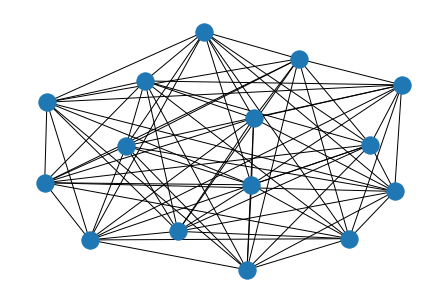

In [ ]:
# Provide number of nodes (must be be multiple of 5)
n = 15

def values(n):
  cluster = int(n/5)                    # 5 is fixed number of nodes per cluster
  return [(5)for i in range(cluster)]

G = nx.complete_multipartite_graph(*values(n))

print(G)
nx.draw(G)

##### *Classical TDA from Giotto library (to compute persistent diagrams)*

In [ ]:
# Create adjacency matrix of graph (as input for Giotto TDA library)
X = nx.adjacency_matrix(G)
np.shape(X)

(15, 15)

In [ ]:
def persistent_homology(X):
  # Instantiate topological transformer
  persistence = VietorisRipsPersistence(
      # Choose maximal homology dimension for TDA
      homology_dimensions=[0, 1, 2, 3, 4, 5],
      metric='precomputed',
      n_jobs=-1,
      reduced_homology=True,
      coeff=2,
      collapse_edges=True,
      max_edge_length=2.0)
  # Compute persistence diagrams corresponding to each graph in X
  diagram = persistence.fit_transform_plot(X)
  return diagram

In [ ]:
# Run classical TDA on k-partite complete graph
diagram = persistent_homology([X])
diagram

In [ ]:
# Get persistent diagram plot up to chosen homology dimension
VietorisRipsPersistence.plot(diagram)

In [ ]:
# Extract total number of topological features per homology dimension
table = pd.DataFrame((NumberOfPoints(n_jobs=-1).fit_transform(diagram)),
                     columns=['H0', 'H1', 'H2', 'H3', 'H4', 'H5'], index=['Topological Features'])
pd.set_option('display.max_rows', None)
table.insert(6, "Sum", table.sum(1))
table

,H0,H1,H2,H3,H4,H5,Sum
Topological Features,14,0,64,0,0,0,78


##### <font color="blue">*Estimate Cost & Auxiliary Functions*

> $T_q=\widetilde{\mathcal{O}}\left(\frac{n|E|}{r \lambda_{\min }} \sqrt{\frac{1}{\beta_{k-1}}\left(\begin{array}{l}n \\ k\end{array}\right)}\right)$ $\quad$ (equation 59)

In [ ]:
def classical_cost(n, E, r, gap, k, betti_k_minus_one):
  """Calculates Toffoli count given parameters to the TDA algorithm.
  Args:
    n: number of vertices
    E: number of edges
    gap: difference between lowest and second lowest eigenvalue of the k-th
      order combinatorial Laplacian
    k: order of Betti number
    betti_k_minus_one: Betti number of order k-1

  Returns:
    Toffoli count
  """
  return n * E * np.sqrt(comb(n, k) / betti_k_minus_one) / (r * gap)

In [ ]:
def get_cliques_of_size(G, k):
  """Gets cliques of a graph.
  Args:
    G: `nx.Graph` problem graph
    k: order of Betti number being estimated

  Returns:
    A 3-tuple of `list`, respectively the cliques of size k-1, k and k+1
  """
  all_cliques = list(nx.enumerate_all_cliques(G))
  lower_cliques = list(filter(lambda x: len(x) == k-1, all_cliques))
  cliques = list(filter(lambda x: len(x) == k, all_cliques))
  upper_cliques = list(filter(lambda x: len(x) == k+1, all_cliques))

  return lower_cliques, cliques, upper_cliques

In [ ]:
def is_upper_clique(clique, upper_clique):
  """Decides if two cliques are adjacent. They have to have difference 1 in size.
  Args:
    clique: the smaller clique
    upper_clique: the larger clique

  Returns:
    Whether upper_clique is clique appended by one number
  """
  return (len(upper_clique) - len(clique) == 1) and (len(set(upper_clique) - set(clique)) == 1)

In [ ]:
def get_number_of_upper_cliques(clique, upper_cliques):
  """Gets number of upper cliques a clique has.
  Args:
    clique: the clique
    upper_cliques: a list with cliques of size 1 larger than clique

  Returns:
    The number of cliques in upper_cliques that are upper to clique.
  """
  total = 0
  for upper_clique in upper_cliques:
    if is_upper_clique(clique, upper_clique):
      total +=1

  return total

In [ ]:
def lower_not_upper_similarity(clique1, clique2, lower_cliques, upper_cliques):
  """Calculates off-diagonal entries of combinatorial Laplacian.

  Args:
    clique1: k-clique indexing the row
    clique2: k-clique indexing the column
    lower_cliques: `list` of (k-1)-cliques
    upper_cliques: `list` of (k+1)-cliques

  Returns:
    The off-diagonal entry at coordinate (clique1, clique2).
  """
  # have common upper?
  for upper_clique in upper_cliques:
    if is_upper_clique(clique1, upper_clique) and is_upper_clique(clique2, upper_clique):
      return 0

  # don't have common upper
  # have common lower?

  # NEW CODE
  # clique1 and clique2 are lower similar if and only if they differ on exactly one vertex
  # Sign is given by the parity of the number of different elements: odd --> +1, even --> -1
  if len(set(clique1).difference(set(clique2)))==1:
    return 2 * (np.count_nonzero(np.array(clique1) - np.array(clique2)) % 2) - 1

  # OLD CODE
  '''
  for lower_clique in lower_cliques:
    if is_upper_clique(lower_clique, clique1) and is_upper_clique(lower_clique, clique2):
     # have a common lower. Need to find similarity.

     diff_inds = []
     diff_elems1 = list(set(clique1) - set(clique2))
     diff_inds.append(clique1.index(diff_elems1[0]))

     diff_elems2 = list(set(clique2) - set(clique1))
     diff_inds.append(clique2.index(diff_elems2[0]))

     if len(diff_inds) == 1:
       sign = 0
     else:
       sign = ((diff_inds[1] - diff_inds[0]) % 2)

     return (-1) ** sign
  '''

  # don't have common lower
  return 0

In [ ]:
### THIS IS ACTUALLY COMPUTING THE ORDER (k-1)
# returns the combinatorial Laplacian of order k of a graph
def get_laplacian(G, k):
  """Computes the k-th order Laplacian of a graph G using theorem 3.3.4 in
  http://www2.stat.duke.edu/~sayan/forkate/CombinatorialLaplacians.pdf.

  Args:
    G: `nx.Graph` input graph
    k: order of Betti number to be estimated

  Returns:
    The matrix of such combinatorial Laplacian.
  """
  # standard Laplacian
  if k==0:
    return nx.laplacian_matrix(G)

  #k += 1
  lower_cliques, cliques, upper_cliques = get_cliques_of_size(G, k)

  n_cliques = len(cliques)
  laplacian = np.zeros((n_cliques, n_cliques))
  for (row, clique_row) in enumerate(cliques):
    for (column, clique_column) in enumerate(cliques):
      # diagonal
      if row == column:
        #laplacian[row][column] = k + 1 + get_number_of_upper_cliques(clique_row, upper_cliques)
        laplacian[row][column] = k + get_number_of_upper_cliques(clique_row, upper_cliques)

      # off-diagonals
      else:
        laplacian[row][column] = lower_not_upper_similarity(clique_row, clique_column, lower_cliques, upper_cliques)

  return laplacian

In [ ]:
def get_laplacian_spectrum(G, k):
  """Computes the eigenvalue spectrum of the k-th order Laplacian of a graph G

  Args:
    G: `nx.Graph` input graph
    k: order of the Betti number being estimated

  Returns:
    `list` of eigenvalues
  """
  laplacian = get_laplacian(G, k)
  eigvals = np.linalg.eigvals(laplacian)
  eigvals = np.sort(eigvals)

  return eigvals

In [ ]:
# calculates combinatorial laplacian gap of a graph G at order k as well as the
# number of zero eigenvalues
def get_laplacian_info(G, k):
  """Computes the difference between the second lowest and lowest eigenvalues
  of the k-th order Laplacian of a graph G

  Args:
    G: `nx.Graph` input graph
    k: order of the Betti number being estimated

  Returns:
    The gap of the Laplacian and the number of zero eigenvalues.
  """
  '''
  laplacian = get_laplacian(G, k)
  eigvals = np.linalg.eigvals(laplacian)
  '''
  eigvals = get_laplacian_spectrum(G, k)
  eigvals = list(map(lambda x: 0 if np.abs(x) < 0.000000000001 else x, list(eigvals)))

  betti_number = eigvals.count(0)

  eigvals = np.unique(eigvals)

  return eigvals[1] - eigvals[0], betti_number

##### <font color="blue">*Cost function*

In [ ]:
def generate_plots(ns, ks):
  """Generates plots of combinatorial laplacian gap, betti number and number
  of Toffolis for a combination of n's and k's.

  Args:
    ns: `list` of `int` of n's
    ks: `list` of `int` of n's
  """
  n_samples = 50
  gaps = [[] for _ in range(len(ks))]
  gap_stds = [[] for _ in range(len(ks))]
  bettis = [[] for _ in range(len(ks))]
  betti_stds = [[] for _ in range(len(ks))]
  costs = [[] for _ in range(len(ks))]
  cost_stds = [[] for _ in range(len(ks))]

  for k_ind, k in enumerate(ks):
    for n in ns:
#      p = n ** (- (2 * k + 1)/float(2 * k * (k + 1)))
      betti_samples = []
      cost_samples = []
      gap_samples = []

      # Subsets of complete multipartite graph with 5 nodes each:
      subsets = [(5)for i in range(int(n/5))]

      for ind in range(n_samples):
        print(f'(k, n, sample) = ({k}, {n}, {ind})')

        # Get graph for different sizes of n
        G = nx.complete_multipartite_graph(*subsets)

#       G = nx.erdos_renyi_graph(n, p)

        gap, betti_number = get_laplacian_info(G, k)
        betti_samples.append(betti_number)
        gap_samples.append(gap)
        cost_samples.append(classical_cost(n, G.number_of_edges(), 0.05, gap, k, betti_number))

      cost_avg = sum(cost_samples) / n_samples
      betti_avg = sum(betti_samples) / float(n_samples)
      gap_avg = sum(gap_samples) / n_samples

      cost_std = statistics.stdev(np.real(cost_samples))
      betti_std = statistics.stdev(np.real(betti_samples))
      gap_std = statistics.stdev(np.real(gap_samples))

      costs[k_ind].append(cost_avg)
      bettis[k_ind].append(betti_avg)
      gaps[k_ind].append(gap_avg)

      cost_stds[k_ind].append(cost_std)
      betti_stds[k_ind].append(betti_std)
      gap_stds[k_ind].append(gap_std)

  fig = plt.figure(figsize=(20, 10))

  #fig.subplots_adjust(hspace=0.4, wspace=0.4)

  ax_costs = fig.add_subplot(1,3,1)
  for k_ind, k in enumerate(ks):
    ax_costs.scatter(ns, costs[k_ind])
    ax_costs.set_xlabel('n')
    ax_costs.set_ylabel('number of Toffolis')
    ax_costs.errorbar(ns, costs[k_ind], yerr=cost_stds[k_ind])
  ax_costs.legend([f'$k = {k}$' for k in ks])

  ax_gaps = fig.add_subplot(1,3,2)
  for k_ind, k in enumerate(ks):
    ax_gaps.scatter(ns, gaps[k_ind])
    ax_gaps.set_xlabel('n')
    ax_gaps.set_ylabel('Gap')
    ax_gaps.errorbar(ns, gaps[k_ind], yerr=gap_stds[k_ind])
  ax_gaps.legend([f'$k = {k}$' for k in ks])

  ax_bettis = fig.add_subplot(1,3,3)
  for k_ind, k in enumerate(ks):
    ax_bettis.scatter(ns, bettis[k_ind])
    ax_bettis.set_xlabel('n')
    ax_bettis.set_ylabel('Betti number')
    ax_bettis.errorbar(ns, bettis[k_ind], yerr=betti_stds[k_ind])
  ax_bettis.legend([f'$k = {k}$' for k in ks])

  plt.tight_layout()
  plt.subplots_adjust()
  plt.show()

##### <font color="blue">*Generate Plots*

In [ ]:
generate_plots([20], [1, 2])

(k, n, sample) = (1, 20, 0)
(k, n, sample) = (1, 20, 1)
(k, n, sample) = (1, 20, 2)
(k, n, sample) = (1, 20, 3)
(k, n, sample) = (1, 20, 4)
(k, n, sample) = (1, 20, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


(k, n, sample) = (1, 20, 6)
(k, n, sample) = (1, 20, 7)
(k, n, sample) = (1, 20, 8)
(k, n, sample) = (1, 20, 9)
(k, n, sample) = (1, 20, 10)
(k, n, sample) = (1, 20, 11)
(k, n, sample) = (1, 20, 12)
(k, n, sample) = (1, 20, 13)
(k, n, sample) = (1, 20, 14)
(k, n, sample) = (1, 20, 15)
(k, n, sample) = (1, 20, 16)
(k, n, sample) = (1, 20, 17)
(k, n, sample) = (1, 20, 18)
(k, n, sample) = (1, 20, 19)
(k, n, sample) = (1, 20, 20)
(k, n, sample) = (1, 20, 21)
(k, n, sample) = (1, 20, 22)
(k, n, sample) = (1, 20, 23)
(k, n, sample) = (1, 20, 24)
(k, n, sample) = (1, 20, 25)
(k, n, sample) = (1, 20, 26)
(k, n, sample) = (1, 20, 27)
(k, n, sample) = (1, 20, 28)
(k, n, sample) = (1, 20, 29)
(k, n, sample) = (1, 20, 30)
(k, n, sample) = (1, 20, 31)
(k, n, sample) = (1, 20, 32)
(k, n, sample) = (1, 20, 33)
(k, n, sample) = (1, 20, 34)
(k, n, sample) = (1, 20, 35)
(k, n, sample) = (1, 20, 36)
(k, n, sample) = (1, 20, 37)
(k, n, sample) = (1, 20, 38)
(k, n, sample) = (1, 20, 39)
(k, n, sample) = (

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(k, n, sample) = (2, 20, 1)
(k, n, sample) = (2, 20, 2)
(k, n, sample) = (2, 20, 3)
(k, n, sample) = (2, 20, 4)
(k, n, sample) = (2, 20, 5)
(k, n, sample) = (2, 20, 6)


#### <font color="blue">***Quantum TDA Test Run***

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.special import comb
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigs
from itertools import product
import statistics

import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
def quantum_cost(n, E, r, gap, k, betti_k_minus_one):
  """Calculates Toffoli count given parameters to the TDA algorithm.
  Args:
    n: number of vertices
    E: number of edges
    gap: difference between lowest and second lowest eigenvalue of the k-th
      order combinatorial Laplacian
    k: order of Betti number
    betti_k_minus_one: Betti number of order k-1

  Returns:
    Toffoli count
  """
  return n * E * np.sqrt(comb(n, k) / betti_k_minus_one) / (r * gap)

In [ ]:
def get_cliques_of_size(G, k):
  """Gets cliques of a graph.
  Args:
    G: `nx.Graph` problem graph
    k: order of Betti number being estimated

  Returns:
    A 3-tuple of `list`, respectively the cliques of size k-1, k and k+1
  """
  all_cliques = list(nx.enumerate_all_cliques(G))
  lower_cliques = list(filter(lambda x: len(x) == k-1, all_cliques))
  cliques = list(filter(lambda x: len(x) == k, all_cliques))
  upper_cliques = list(filter(lambda x: len(x) == k+1, all_cliques))

  return lower_cliques, cliques, upper_cliques

In [ ]:
def is_upper_clique(clique, upper_clique):
  """Decides if two cliques are adjacent. They have to have difference 1 in size.
  Args:
    clique: the smaller clique
    upper_clique: the larger clique

  Returns:
    Whether upper_clique is clique appended by one number
  """
  return (len(upper_clique) - len(clique) == 1) and (len(set(upper_clique) - set(clique)) == 1)

In [ ]:
def get_number_of_upper_cliques(clique, upper_cliques):
  """Gets number of upper cliques a clique has.
  Args:
    clique: the clique
    upper_cliques: a list with cliques of size 1 larger than clique

  Returns:
    The number of cliques in upper_cliques that are upper to clique.
  """
  total = 0
  for upper_clique in upper_cliques:
    if is_upper_clique(clique, upper_clique):
      total +=1

  return total

In [ ]:
def lower_not_upper_similarity(clique1, clique2, lower_cliques, upper_cliques):
  """Calculates off-diagonal entries of combinatorial Laplacian.

  Args:
    clique1: k-clique indexing the row
    clique2: k-clique indexing the column
    lower_cliques: `list` of (k-1)-cliques
    upper_cliques: `list` of (k+1)-cliques

  Returns:
    The off-diagonal entry at coordinate (clique1, clique2).
  """
  # have common upper?
  for upper_clique in upper_cliques:
    if is_upper_clique(clique1, upper_clique) and is_upper_clique(clique2, upper_clique):
      return 0

  # don't have common upper
  # have common lower?

  # NEW CODE
  # clique1 and clique2 are lower similar if and only if they differ on exactly one vertex
  # Sign is given by the parity of the number of different elements: odd --> +1, even --> -1
  if len(set(clique1).difference(set(clique2)))==1:
    return 2 * (np.count_nonzero(np.array(clique1) - np.array(clique2)) % 2) - 1

  # OLD CODE
  '''
  for lower_clique in lower_cliques:
    if is_upper_clique(lower_clique, clique1) and is_upper_clique(lower_clique, clique2):
     # have a common lower. Need to find similarity.

     diff_inds = []
     diff_elems1 = list(set(clique1) - set(clique2))
     diff_inds.append(clique1.index(diff_elems1[0]))

     diff_elems2 = list(set(clique2) - set(clique1))
     diff_inds.append(clique2.index(diff_elems2[0]))

     if len(diff_inds) == 1:
       sign = 0
     else:
       sign = ((diff_inds[1] - diff_inds[0]) % 2)

     return (-1) ** sign
  '''

  # don't have common lower
  return 0

In [ ]:
### THIS IS ACTUALLY COMPUTING THE ORDER (k-1)
# returns the combinatorial Laplacian of order k of a graph
def get_laplacian(G, k):
  """Computes the k-th order Laplacian of a graph G using theorem 3.3.4 in
  http://www2.stat.duke.edu/~sayan/forkate/CombinatorialLaplacians.pdf.

  Args:
    G: `nx.Graph` input graph
    k: order of Betti number to be estimated

  Returns:
    The matrix of such combinatorial Laplacian.
  """
  # standard Laplacian
  if k==0:
    return nx.laplacian_matrix(G)

  #k += 1
  lower_cliques, cliques, upper_cliques = get_cliques_of_size(G, k)

  n_cliques = len(cliques)
  laplacian = np.zeros((n_cliques, n_cliques))
  for (row, clique_row) in enumerate(cliques):
    for (column, clique_column) in enumerate(cliques):
      # diagonal
      if row == column:
        #laplacian[row][column] = k + 1 + get_number_of_upper_cliques(clique_row, upper_cliques)
        laplacian[row][column] = k + get_number_of_upper_cliques(clique_row, upper_cliques)

      # off-diagonals
      else:
        laplacian[row][column] = lower_not_upper_similarity(clique_row, clique_column, lower_cliques, upper_cliques)

  return laplacian

In [ ]:
def get_laplacian_spectrum(G, k):
  """Computes the eigenvalue spectrum of the k-th order Laplacian of a graph G

  Args:
    G: `nx.Graph` input graph
    k: order of the Betti number being estimated

  Returns:
    `list` of eigenvalues
  """
  laplacian = get_laplacian(G, k)
  eigvals = np.linalg.eigvals(laplacian)
  eigvals = np.sort(eigvals)

  return eigvals

In [ ]:
# calculates combinatorial laplacian gap of a graph G at order k as well as the
# number of zero eigenvalues
def get_laplacian_info(G, k):
  """Computes the difference between the second lowest and lowest eigenvalues
  of the k-th order Laplacian of a graph G

  Args:
    G: `nx.Graph` input graph
    k: order of the Betti number being estimated

  Returns:
    The gap of the Laplacian and the number of zero eigenvalues.
  """
  '''
  laplacian = get_laplacian(G, k)
  eigvals = np.linalg.eigvals(laplacian)
  '''
  eigvals = get_laplacian_spectrum(G, k)
  eigvals = list(map(lambda x: 0 if np.abs(x) < 0.000000000001 else x, list(eigvals)))

  betti_number = eigvals.count(0)

  eigvals = np.unique(eigvals)

  return eigvals[1] - eigvals[0], betti_number

(k, n, sample) = (1, 10, 0)
(k, n, sample) = (1, 10, 1)
(k, n, sample) = (1, 10, 2)
(k, n, sample) = (1, 10, 3)
(k, n, sample) = (1, 10, 4)
(k, n, sample) = (1, 10, 5)
(k, n, sample) = (1, 10, 6)
(k, n, sample) = (1, 10, 7)
(k, n, sample) = (1, 10, 8)
(k, n, sample) = (1, 10, 9)
(k, n, sample) = (1, 10, 10)
(k, n, sample) = (1, 10, 11)
(k, n, sample) = (1, 10, 12)
(k, n, sample) = (1, 10, 13)
(k, n, sample) = (1, 10, 14)
(k, n, sample) = (1, 10, 15)
(k, n, sample) = (1, 10, 16)
(k, n, sample) = (1, 10, 17)
(k, n, sample) = (1, 10, 18)
(k, n, sample) = (1, 10, 19)
(k, n, sample) = (1, 10, 20)
(k, n, sample) = (1, 10, 21)
(k, n, sample) = (1, 10, 22)
(k, n, sample) = (1, 10, 23)
(k, n, sample) = (1, 10, 24)
(k, n, sample) = (1, 10, 25)
(k, n, sample) = (1, 10, 26)
(k, n, sample) = (1, 10, 27)
(k, n, sample) = (1, 10, 28)
(k, n, sample) = (1, 10, 29)
(k, n, sample) = (1, 10, 30)
(k, n, sample) = (1, 10, 31)
(k, n, sample) = (1, 10, 32)
(k, n, sample) = (1, 10, 33)
(k, n, sample) = (1, 10,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


(k, n, sample) = (1, 10, 136)
(k, n, sample) = (1, 10, 137)
(k, n, sample) = (1, 10, 138)
(k, n, sample) = (1, 10, 139)
(k, n, sample) = (1, 10, 140)
(k, n, sample) = (1, 10, 141)
(k, n, sample) = (1, 10, 142)
(k, n, sample) = (1, 10, 143)
(k, n, sample) = (1, 10, 144)
(k, n, sample) = (1, 10, 145)
(k, n, sample) = (1, 10, 146)
(k, n, sample) = (1, 10, 147)
(k, n, sample) = (1, 10, 148)
(k, n, sample) = (1, 10, 149)
(k, n, sample) = (1, 10, 150)
(k, n, sample) = (1, 10, 151)
(k, n, sample) = (1, 10, 152)
(k, n, sample) = (1, 10, 153)
(k, n, sample) = (1, 10, 154)
(k, n, sample) = (1, 10, 155)
(k, n, sample) = (1, 10, 156)
(k, n, sample) = (1, 10, 157)
(k, n, sample) = (1, 10, 158)
(k, n, sample) = (1, 10, 159)
(k, n, sample) = (1, 10, 160)
(k, n, sample) = (1, 10, 161)
(k, n, sample) = (1, 10, 162)
(k, n, sample) = (1, 10, 163)
(k, n, sample) = (1, 10, 164)
(k, n, sample) = (1, 10, 165)
(k, n, sample) = (1, 10, 166)
(k, n, sample) = (1, 10, 167)
(k, n, sample) = (1, 10, 168)
(k, n, sam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  



(k, n, sample) = (1, 10, 1442)
(k, n, sample) = (1, 10, 1443)
(k, n, sample) = (1, 10, 1444)
(k, n, sample) = (1, 10, 1445)
(k, n, sample) = (1, 10, 1446)
(k, n, sample) = (1, 10, 1447)
(k, n, sample) = (1, 10, 1448)
(k, n, sample) = (1, 10, 1449)
(k, n, sample) = (1, 10, 1450)
(k, n, sample) = (1, 10, 1451)
(k, n, sample) = (1, 10, 1452)
(k, n, sample) = (1, 10, 1453)
(k, n, sample) = (1, 10, 1454)
(k, n, sample) = (1, 10, 1455)
(k, n, sample) = (1, 10, 1456)
(k, n, sample) = (1, 10, 1457)
(k, n, sample) = (1, 10, 1458)
(k, n, sample) = (1, 10, 1459)
(k, n, sample) = (1, 10, 1460)
(k, n, sample) = (1, 10, 1461)
(k, n, sample) = (1, 10, 1462)
(k, n, sample) = (1, 10, 1463)
(k, n, sample) = (1, 10, 1464)
(k, n, sample) = (1, 10, 1465)
(k, n, sample) = (1, 10, 1466)
(k, n, sample) = (1, 10, 1467)
(k, n, sample) = (1, 10, 1468)
(k, n, sample) = (1, 10, 1469)
(k, n, sample) = (1, 10, 1470)
(k, n, sample) = (1, 10, 1471)
(k, n, sample) = (1, 10, 1472)
(k, n, sample) = (1, 10, 1473)
(k, n, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in cdouble_scalars


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
(k, n, sample) = (2, 20, 1000)
(k, n, sample) = (2, 20, 1001)
(k, n, sample) = (2, 20, 1002)
(k, n, sample) = (2, 20, 1003)
(k, n, sample) = (2, 20, 1004)
(k, n, sample) = (2, 20, 1005)
(k, n, sample) = (2, 20, 1006)
(k, n, sample) = (2, 20, 1007)
(k, n, sample) = (2, 20, 1008)
(k, n, sample) = (2, 20, 1009)
(k, n, sample) = (2, 20, 1010)
(k, n, sample) = (2, 20, 1011)
(k, n, sample) = (2, 20, 1012)
(k, n, sample) = (2, 20, 1013)
(k, n, sample) = (2, 20, 1014)
(k, n, sample) = (2, 20, 1015)
(k, n, sample) = (2, 20, 1016)
(k, n, sample) = (2, 20, 1017)
(k, n, sample) = (2, 20, 1018)
(k, n, sample) = (2, 20, 1019)
(k, n, sample) = (2, 20, 1020)
(k, n, sample) = (2, 20, 1021)
(k, n, sample) = (2, 20, 1022)
(k, n, sample) = (2, 20, 1023)
(k, n, sample) = (2, 20, 1024)
(k, n, sample) = (2, 20, 1025)
(k, n, sample) = (2, 20, 1026)
(k, n, sample) = (2, 20, 1027)
(k, n, sample) = (2, 20, 1028)
(k, n, sample) = (2, 20, 1029)
(k,

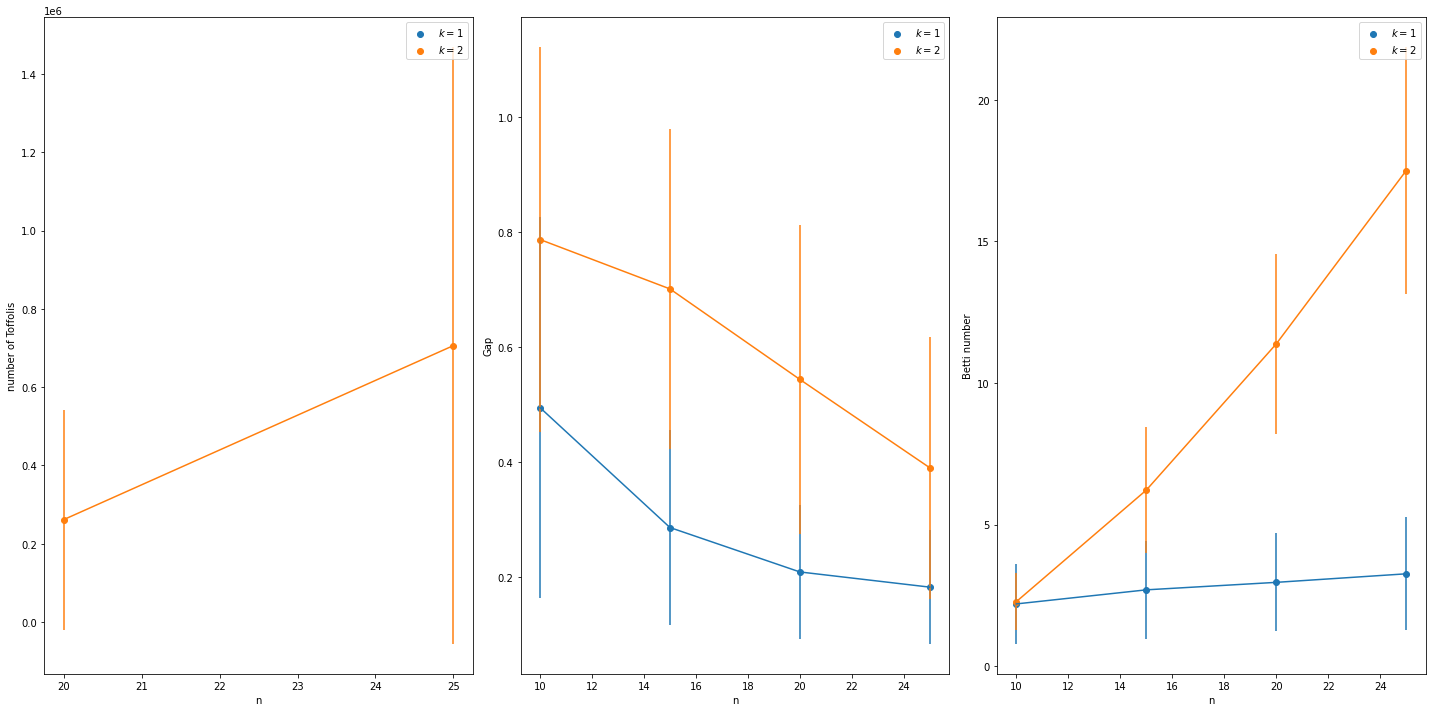

In [ ]:
#@title
# old code with non log data

def generate_plots(ns, ks):
  """Generates plots of combinatorial laplacian gap, betti number and number
  of Toffolis for a combination of n's and k's.

  Args:
    ns: `list` of `int` of n's
    ks: `list` of `int` of n's
  """
  n_samples = 3000
  gaps = [[] for _ in range(len(ks))]
  gap_stds = [[] for _ in range(len(ks))]
  bettis = [[] for _ in range(len(ks))]
  betti_stds = [[] for _ in range(len(ks))]
  costs = [[] for _ in range(len(ks))]
  cost_stds = [[] for _ in range(len(ks))]

  for k_ind, k in enumerate(ks):
    for n in ns:
      p = n ** (- (2 * k + 1)/float(2 * k * (k + 1)))
      betti_samples = []
      cost_samples = []
      gap_samples = []
      for ind in range(n_samples):
        print(f'(k, n, sample) = ({k}, {n}, {ind})')
        G = nx.erdos_renyi_graph(n, p)
        gap, betti_number = get_laplacian_info(G, k)
        betti_samples.append(betti_number)
        gap_samples.append(gap)
        cost_samples.append(quantum_cost(n, G.number_of_edges(), 0.05, gap, k, betti_number))

      cost_avg = sum(cost_samples) / n_samples
      betti_avg = sum(betti_samples) / float(n_samples)
      gap_avg = sum(gap_samples) / n_samples

      cost_std = statistics.stdev(np.real(cost_samples))
      betti_std = statistics.stdev(np.real(betti_samples))
      gap_std = statistics.stdev(np.real(gap_samples))

      costs[k_ind].append(cost_avg)
      bettis[k_ind].append(betti_avg)
      gaps[k_ind].append(gap_avg)

      cost_stds[k_ind].append(cost_std)
      betti_stds[k_ind].append(betti_std)
      gap_stds[k_ind].append(gap_std)

  fig = plt.figure(figsize=(20, 10))

  #fig.subplots_adjust(hspace=0.4, wspace=0.4)

  ax_costs = fig.add_subplot(1,3,1)
  for k_ind, k in enumerate(ks):
    ax_costs.scatter(ns, costs[k_ind])
    ax_costs.set_xlabel('n')
    ax_costs.set_ylabel('number of Toffolis')
    ax_costs.errorbar(ns, costs[k_ind], yerr=cost_stds[k_ind])
  ax_costs.legend([f'$k = {k}$' for k in ks])

  ax_gaps = fig.add_subplot(1,3,2)
  for k_ind, k in enumerate(ks):
    ax_gaps.scatter(ns, gaps[k_ind])
    ax_gaps.set_xlabel('n')
    ax_gaps.set_ylabel('Gap')
    ax_gaps.errorbar(ns, gaps[k_ind], yerr=gap_stds[k_ind])
  ax_gaps.legend([f'$k = {k}$' for k in ks])

  ax_bettis = fig.add_subplot(1,3,3)
  for k_ind, k in enumerate(ks):
    ax_bettis.scatter(ns, bettis[k_ind])
    ax_bettis.set_xlabel('n')
    ax_bettis.set_ylabel('Betti number')
    ax_bettis.errorbar(ns, bettis[k_ind], yerr=betti_stds[k_ind])
  ax_bettis.legend([f'$k = {k}$' for k in ks])

  plt.tight_layout()
  plt.subplots_adjust()
  plt.show()

generate_plots([10, 15, 20, 25], [1,2])

**Try to plot things on a log / log plot so that we can try to infer the polynomial order of the gap scaling:**

In [ ]:
def generate_plots(ns, ks):
  """Generates plots of combinatorial laplacian gap, betti number and number
  of Toffolis for a combination of n's and k's.

  Args:
    ns: `list` of `int` of n's
    ks: `list` of `int` of n's
  """
  n_samples = 100
  gaps = [[] for _ in range(len(ks))]
  gap_stds = [[] for _ in range(len(ks))]
  bettis = [[] for _ in range(len(ks))]
  betti_stds = [[] for _ in range(len(ks))]
  costs = [[] for _ in range(len(ks))]
  cost_stds = [[] for _ in range(len(ks))]

  for k_ind, k in enumerate(ks):
    for n in ns:
      p = n ** (- (2 * k + 1)/float(2 * k * (k + 1)))
      betti_samples = []
      cost_samples = []
      gap_samples = []
      for ind in range(n_samples):
        print(f'(k, n, sample) = ({k}, {n}, {ind})')
        G = nx.erdos_renyi_graph(n, p)
        gap, betti_number = get_laplacian_info(G, k)
        betti_samples.append(betti_number)
        gap_samples.append(gap)
        cost_samples.append(quantum_cost(n, G.number_of_edges(), 0.05, gap, k, betti_number))

      cost_avg = sum(cost_samples) / n_samples
      betti_avg = sum(betti_samples) / float(n_samples)
      gap_avg = sum(gap_samples) / n_samples

      cost_std = statistics.stdev(np.real(cost_samples))
      betti_std = statistics.stdev(np.real(betti_samples))
      gap_std = statistics.stdev(np.real(gap_samples))

      costs[k_ind].append(cost_avg)
      bettis[k_ind].append(betti_avg)
      gaps[k_ind].append(gap_avg)

      cost_stds[k_ind].append(cost_std)
      betti_stds[k_ind].append(betti_std)
      gap_stds[k_ind].append(gap_std)

  fig = plt.figure(figsize=(20, 10))

  #fig.subplots_adjust(hspace=0.4, wspace=0.4)

  ax_costs = fig.add_subplot(1,3,1)
  for k_ind, k in enumerate(ks):
    ax_costs.scatter(np.log(ns), np.log(costs[k_ind]))
    ax_costs.set_xlabel('log of n')
    ax_costs.set_ylabel('log of number of Toffolis')
    ax_costs.errorbar(np.log(ns), np.log(costs[k_ind]), yerr=np.log(cost_stds[k_ind]))
  ax_costs.legend([f'$k = {k}$' for k in ks])

  ax_gaps = fig.add_subplot(1,3,2)
  for k_ind, k in enumerate(ks):
    ax_gaps.scatter(np.log(ns), np.log(gaps[k_ind]))
    ax_gaps.set_xlabel('log of n')
    ax_gaps.set_ylabel('log of Gap')
    ax_gaps.errorbar(np.log(ns), np.log(gaps[k_ind]), yerr=np.log(gap_stds[k_ind]))
  ax_gaps.legend([f'$k = {k}$' for k in ks])

  ax_bettis = fig.add_subplot(1,3,3)
  for k_ind, k in enumerate(ks):
    ax_bettis.scatter(np.log(ns), np.log(bettis[k_ind]))
    ax_bettis.set_xlabel('log of n')
    ax_bettis.set_ylabel('log of Betti number')
    ax_bettis.errorbar(np.log(ns), np.log(bettis[k_ind]), yerr=np.log(betti_stds[k_ind]))
  ax_bettis.legend([f'$k = {k}$' for k in ks])

  plt.tight_layout()
  plt.subplots_adjust()
  plt.show()

generate_plots([25], [8])

(k, n, sample) = (8, 25, 0)
(k, n, sample) = (8, 25, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


IndexError: ignored

#### <font color="blue">***CPU Performance Test Run***

##### *Simple Example*

In [ ]:
import math
import sympy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from psutil import *
cpu_count()

2

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes

    CPU Performance in sec
5                 0.000021
10                0.000044
15                0.000499
20                0.004968
25                0.051973


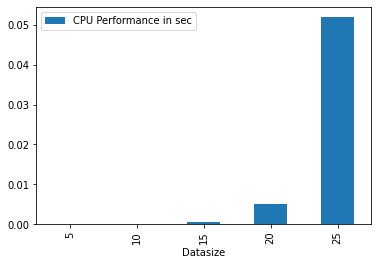

In [ ]:
# Compute and display complexity of Fibonacci

import time

def fibonacci(n):
    if n <= 1:
        return n
    return fibonacci(n-1) + fibonacci(n-2)


# My input data for the function
my_tuple = 5,10,15,20,25

# Define empty bucket
rows_list = []

for n in my_tuple:

    # Begin tracking CPU time
    st = time.process_time(),

    # Run algorithms
    result = fibonacci(n),

    # Finish tracking CPU time
    et = time.process_time(),

    # Calculate performance (end - begin)
    performance = [x - y for x, y in zip(list(et), list(st))]

    # Collect results in a list
    rows_list.append(performance)

# Write results in a table
df = pd.DataFrame(rows_list, index=my_tuple, columns=['CPU Performance in sec'])
print(df)

# Visualize results in a graph
df = df.reset_index().rename(columns={"index": "Datasize"})
df.plot(x ='Datasize', y='CPU Performance in sec', kind = 'bar')

##### *Code for Generating plots of combinatorial laplacian gap, betti number and number of Toffolis for a combination of n's and k's*

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.special import comb
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigs
from itertools import product
import statistics

import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
def quantum_cost(n, E, r, gap, k, betti_k_minus_one):
  """Calculates Toffoli count given parameters to the TDA algorithm.
  Args:
    n: number of vertices
    E: number of edges
    gap: difference between lowest and second lowest eigenvalue of the k-th
      order combinatorial Laplacian
    k: order of Betti number
    betti_k_minus_one: Betti number of order k-1

  Returns:
    Toffoli count
  """
  return n * E * np.sqrt(comb(n, k) / betti_k_minus_one) / (r * gap)

In [ ]:
def get_cliques_of_size(G, k):
  """Gets cliques of a graph.
  Args:
    G: `nx.Graph` problem graph
    k: order of Betti number being estimated

  Returns:
    A 3-tuple of `list`, respectively the cliques of size k-1, k and k+1
  """
  all_cliques = list(nx.enumerate_all_cliques(G))
  lower_cliques = list(filter(lambda x: len(x) == k-1, all_cliques))
  cliques = list(filter(lambda x: len(x) == k, all_cliques))
  upper_cliques = list(filter(lambda x: len(x) == k+1, all_cliques))

  return lower_cliques, cliques, upper_cliques

In [ ]:
def is_upper_clique(clique, upper_clique):
  """Decides if two cliques are adjacent. They have to have difference 1 in size.
  Args:
    clique: the smaller clique
    upper_clique: the larger clique

  Returns:
    Whether upper_clique is clique appended by one number
  """
  return (len(upper_clique) - len(clique) == 1) and (len(set(upper_clique) - set(clique)) == 1)

In [ ]:
def get_number_of_upper_cliques(clique, upper_cliques):
  """Gets number of upper cliques a clique has.
  Args:
    clique: the clique
    upper_cliques: a list with cliques of size 1 larger than clique

  Returns:
    The number of cliques in upper_cliques that are upper to clique.
  """
  total = 0
  for upper_clique in upper_cliques:
    if is_upper_clique(clique, upper_clique):
      total +=1

  return total

In [ ]:
def lower_not_upper_similarity(clique1, clique2, lower_cliques, upper_cliques):
  """Calculates off-diagonal entries of combinatorial Laplacian.

  Args:
    clique1: k-clique indexing the row
    clique2: k-clique indexing the column
    lower_cliques: `list` of (k-1)-cliques
    upper_cliques: `list` of (k+1)-cliques

  Returns:
    The off-diagonal entry at coordinate (clique1, clique2).
  """
  # have common upper?
  for upper_clique in upper_cliques:
    if is_upper_clique(clique1, upper_clique) and is_upper_clique(clique2, upper_clique):
      return 0

  # don't have common upper
  # have common lower?

  # NEW CODE
  # clique1 and clique2 are lower similar if and only if they differ on exactly one vertex
  # Sign is given by the parity of the number of different elements: odd --> +1, even --> -1
  if len(set(clique1).difference(set(clique2)))==1:
    return 2 * (np.count_nonzero(np.array(clique1) - np.array(clique2)) % 2) - 1

  # OLD CODE
  '''
  for lower_clique in lower_cliques:
    if is_upper_clique(lower_clique, clique1) and is_upper_clique(lower_clique, clique2):
     # have a common lower. Need to find similarity.

     diff_inds = []
     diff_elems1 = list(set(clique1) - set(clique2))
     diff_inds.append(clique1.index(diff_elems1[0]))

     diff_elems2 = list(set(clique2) - set(clique1))
     diff_inds.append(clique2.index(diff_elems2[0]))

     if len(diff_inds) == 1:
       sign = 0
     else:
       sign = ((diff_inds[1] - diff_inds[0]) % 2)

     return (-1) ** sign
  '''

  # don't have common lower
  return 0

In [ ]:
### THIS IS ACTUALLY COMPUTING THE ORDER (k-1)
# returns the combinatorial Laplacian of order k of a graph
def get_laplacian(G, k):
  """Computes the k-th order Laplacian of a graph G using theorem 3.3.4 in
  http://www2.stat.duke.edu/~sayan/forkate/CombinatorialLaplacians.pdf.

  Args:
    G: `nx.Graph` input graph
    k: order of Betti number to be estimated

  Returns:
    The matrix of such combinatorial Laplacian.
  """
  # standard Laplacian
  if k==0:
    return nx.laplacian_matrix(G)

  #k += 1
  lower_cliques, cliques, upper_cliques = get_cliques_of_size(G, k)

  n_cliques = len(cliques)
  laplacian = np.zeros((n_cliques, n_cliques))
  for (row, clique_row) in enumerate(cliques):
    for (column, clique_column) in enumerate(cliques):
      # diagonal
      if row == column:
        #laplacian[row][column] = k + 1 + get_number_of_upper_cliques(clique_row, upper_cliques)
        laplacian[row][column] = k + get_number_of_upper_cliques(clique_row, upper_cliques)

      # off-diagonals
      else:
        laplacian[row][column] = lower_not_upper_similarity(clique_row, clique_column, lower_cliques, upper_cliques)

  return laplacian

In [ ]:
def get_laplacian_spectrum(G, k):
  """Computes the eigenvalue spectrum of the k-th order Laplacian of a graph G

  Args:
    G: `nx.Graph` input graph
    k: order of the Betti number being estimated

  Returns:
    `list` of eigenvalues
  """
  laplacian = get_laplacian(G, k)
  eigvals = np.linalg.eigvals(laplacian)
  eigvals = np.sort(eigvals)

  return eigvals

In [ ]:
# calculates combinatorial laplacian gap of a graph G at order k as well as the
# number of zero eigenvalues
def get_laplacian_info(G, k):
  """Computes the difference between the second lowest and lowest eigenvalues
  of the k-th order Laplacian of a graph G

  Args:
    G: `nx.Graph` input graph
    k: order of the Betti number being estimated

  Returns:
    The gap of the Laplacian and the number of zero eigenvalues.
  """
  '''
  laplacian = get_laplacian(G, k)
  eigvals = np.linalg.eigvals(laplacian)
  '''
  eigvals = get_laplacian_spectrum(G, k)
  eigvals = list(map(lambda x: 0 if np.abs(x) < 0.000000000001 else x, list(eigvals)))

  betti_number = eigvals.count(0)

  eigvals = np.unique(eigvals)

  return eigvals[1] - eigvals[0], betti_number

In [ ]:
def generate_plots(ns, ks):
  """Generates plots of combinatorial laplacian gap, betti number and number
  of Toffolis for a combination of n's and k's.

  Args:
    ns: `list` of `int` of n's
    ks: `list` of `int` of n's
  """
  n_samples = 50
  gaps = [[] for _ in range(len(ks))]
  gap_stds = [[] for _ in range(len(ks))]
  bettis = [[] for _ in range(len(ks))]
  betti_stds = [[] for _ in range(len(ks))]
  costs = [[] for _ in range(len(ks))]
  cost_stds = [[] for _ in range(len(ks))]

  for k_ind, k in enumerate(ks):
    for n in ns:
      p = n ** (- (2 * k + 1)/float(2 * k * (k + 1)))
      betti_samples = []
      cost_samples = []
      gap_samples = []
      for ind in range(n_samples):
        print(f'(k, n, sample) = ({k}, {n}, {ind})')
        G = nx.erdos_renyi_graph(n, p)
        gap, betti_number = get_laplacian_info(G, k)
        betti_samples.append(betti_number)
        gap_samples.append(gap)
        cost_samples.append(quantum_cost(n, G.number_of_edges(), 0.05, gap, k, betti_number))

      cost_avg = sum(cost_samples) / n_samples
      betti_avg = sum(betti_samples) / float(n_samples)
      gap_avg = sum(gap_samples) / n_samples

      cost_std = statistics.stdev(np.real(cost_samples))
      betti_std = statistics.stdev(np.real(betti_samples))
      gap_std = statistics.stdev(np.real(gap_samples))

      costs[k_ind].append(cost_avg)
      bettis[k_ind].append(betti_avg)
      gaps[k_ind].append(gap_avg)

      cost_stds[k_ind].append(cost_std)
      betti_stds[k_ind].append(betti_std)
      gap_stds[k_ind].append(gap_std)

## Alex --->  I removed all plotting options from here to reduce CPU time

#generate_plots([25], [1])

##### *CPU Performance Calculation*

(k, n, sample) = (1, 10, 0)
(k, n, sample) = (1, 10, 1)
(k, n, sample) = (1, 10, 2)
(k, n, sample) = (1, 10, 3)
(k, n, sample) = (1, 10, 4)
(k, n, sample) = (1, 10, 5)
(k, n, sample) = (1, 10, 6)
(k, n, sample) = (1, 10, 7)
(k, n, sample) = (1, 10, 8)
(k, n, sample) = (1, 10, 9)
(k, n, sample) = (1, 10, 10)
(k, n, sample) = (1, 10, 11)
(k, n, sample) = (1, 10, 12)
(k, n, sample) = (1, 10, 13)
(k, n, sample) = (1, 10, 14)
(k, n, sample) = (1, 10, 15)
(k, n, sample) = (1, 10, 16)
(k, n, sample) = (1, 10, 17)
(k, n, sample) = (1, 10, 18)
(k, n, sample) = (1, 10, 19)
(k, n, sample) = (1, 10, 20)
(k, n, sample) = (1, 10, 21)
(k, n, sample) = (1, 10, 22)
(k, n, sample) = (1, 10, 23)
(k, n, sample) = (1, 10, 24)
(k, n, sample) = (1, 10, 25)
(k, n, sample) = (1, 10, 26)
(k, n, sample) = (1, 10, 27)
(k, n, sample) = (1, 10, 28)
(k, n, sample) = (1, 10, 29)
(k, n, sample) = (1, 10, 30)
(k, n, sample) = (1, 10, 31)
(k, n, sample) = (1, 10, 32)
(k, n, sample) = (1, 10, 33)
(k, n, sample) = (1, 10,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in cdouble_scalars
/usr/lib/python3.7/statistics.py:535: RuntimeWarning: invalid value encountered in double_scalars
  T, total, count = _sum((x-c)**2 for x in data)
/usr/lib/python3.7/statistics.py:538: RuntimeWarning: invalid value encountered in double_scalars
  U, total2, count2 = _sum((x-c) for x in data)


(k, n, sample) = (1, 15, 33)
(k, n, sample) = (1, 15, 34)
(k, n, sample) = (1, 15, 35)
(k, n, sample) = (1, 15, 36)
(k, n, sample) = (1, 15, 37)
(k, n, sample) = (1, 15, 38)
(k, n, sample) = (1, 15, 39)
(k, n, sample) = (1, 15, 40)
(k, n, sample) = (1, 15, 41)
(k, n, sample) = (1, 15, 42)
(k, n, sample) = (1, 15, 43)
(k, n, sample) = (1, 15, 44)
(k, n, sample) = (1, 15, 45)
(k, n, sample) = (1, 15, 46)
(k, n, sample) = (1, 15, 47)
(k, n, sample) = (1, 15, 48)
(k, n, sample) = (1, 15, 49)
(k, n, sample) = (1, 20, 0)
(k, n, sample) = (1, 20, 1)
(k, n, sample) = (1, 20, 2)
(k, n, sample) = (1, 20, 3)
(k, n, sample) = (1, 20, 4)
(k, n, sample) = (1, 20, 5)
(k, n, sample) = (1, 20, 6)
(k, n, sample) = (1, 20, 7)
(k, n, sample) = (1, 20, 8)
(k, n, sample) = (1, 20, 9)
(k, n, sample) = (1, 20, 10)
(k, n, sample) = (1, 20, 11)
(k, n, sample) = (1, 20, 12)
(k, n, sample) = (1, 20, 13)
(k, n, sample) = (1, 20, 14)
(k, n, sample) = (1, 20, 15)
(k, n, sample) = (1, 20, 16)
(k, n, sample) = (1, 20,

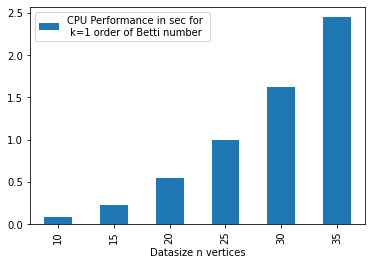

In [ ]:
import time

rows_list = []

my_tuple = [10, 15, 20, 25, 30, 35]

for num in my_tuple:
    st = time.process_time(),
    generate_plots([num], [1]),
    et = time.process_time(),
    performance = [x - y for x, y in zip(list(et), list(st))]
    rows_list.append(performance)

df = pd.DataFrame(rows_list, index=[*(my_tuple)], columns=['CPU Performance in sec for \n k=1 order of Betti number'])
df['Growth'] = df.diff()
print(df)
df = df.reset_index().rename(columns={"index": "Datasize n vertices"})
df.plot(x ='Datasize n vertices', y='CPU Performance in sec for \n k=1 order of Betti number', kind = 'bar')

(k, n, sample) = (2, 10, 0)
(k, n, sample) = (2, 10, 1)
(k, n, sample) = (2, 10, 2)
(k, n, sample) = (2, 10, 3)
(k, n, sample) = (2, 10, 4)
(k, n, sample) = (2, 10, 5)
(k, n, sample) = (2, 10, 6)
(k, n, sample) = (2, 10, 7)
(k, n, sample) = (2, 10, 8)
(k, n, sample) = (2, 10, 9)
(k, n, sample) = (2, 10, 10)
(k, n, sample) = (2, 10, 11)
(k, n, sample) = (2, 10, 12)
(k, n, sample) = (2, 10, 13)
(k, n, sample) = (2, 10, 14)
(k, n, sample) = (2, 10, 15)
(k, n, sample) = (2, 10, 16)
(k, n, sample) = (2, 10, 17)
(k, n, sample) = (2, 10, 18)
(k, n, sample) = (2, 10, 19)
(k, n, sample) = (2, 10, 20)
(k, n, sample) = (2, 10, 21)
(k, n, sample) = (2, 10, 22)
(k, n, sample) = (2, 10, 23)
(k, n, sample) = (2, 10, 24)
(k, n, sample) = (2, 10, 25)
(k, n, sample) = (2, 10, 26)
(k, n, sample) = (2, 10, 27)
(k, n, sample) = (2, 10, 28)
(k, n, sample) = (2, 10, 29)
(k, n, sample) = (2, 10, 30)
(k, n, sample) = (2, 10, 31)
(k, n, sample) = (2, 10, 32)
(k, n, sample) = (2, 10, 33)
(k, n, sample) = (2, 10,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in cdouble_scalars
/usr/lib/python3.7/statistics.py:535: RuntimeWarning: invalid value encountered in double_scalars
  T, total, count = _sum((x-c)**2 for x in data)
/usr/lib/python3.7/statistics.py:538: RuntimeWarning: invalid value encountered in double_scalars
  U, total2, count2 = _sum((x-c) for x in data)


(k, n, sample) = (2, 15, 7)
(k, n, sample) = (2, 15, 8)
(k, n, sample) = (2, 15, 9)
(k, n, sample) = (2, 15, 10)
(k, n, sample) = (2, 15, 11)
(k, n, sample) = (2, 15, 12)
(k, n, sample) = (2, 15, 13)
(k, n, sample) = (2, 15, 14)
(k, n, sample) = (2, 15, 15)
(k, n, sample) = (2, 15, 16)
(k, n, sample) = (2, 15, 17)
(k, n, sample) = (2, 15, 18)
(k, n, sample) = (2, 15, 19)
(k, n, sample) = (2, 15, 20)
(k, n, sample) = (2, 15, 21)
(k, n, sample) = (2, 15, 22)
(k, n, sample) = (2, 15, 23)
(k, n, sample) = (2, 15, 24)
(k, n, sample) = (2, 15, 25)
(k, n, sample) = (2, 15, 26)
(k, n, sample) = (2, 15, 27)
(k, n, sample) = (2, 15, 28)
(k, n, sample) = (2, 15, 29)
(k, n, sample) = (2, 15, 30)
(k, n, sample) = (2, 15, 31)
(k, n, sample) = (2, 15, 32)
(k, n, sample) = (2, 15, 33)
(k, n, sample) = (2, 15, 34)
(k, n, sample) = (2, 15, 35)
(k, n, sample) = (2, 15, 36)
(k, n, sample) = (2, 15, 37)
(k, n, sample) = (2, 15, 38)
(k, n, sample) = (2, 15, 39)
(k, n, sample) = (2, 15, 40)
(k, n, sample) = 

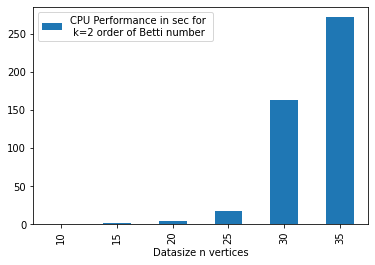

In [ ]:
import time

rows_list = []

my_tuple = [10, 15, 20, 25, 30, 35]

for num in my_tuple:
    st = time.process_time(),
    generate_plots([num], [2]),
    et = time.process_time(),
    performance = [x - y for x, y in zip(list(et), list(st))]
    rows_list.append(performance)

df = pd.DataFrame(rows_list, index=[*(my_tuple)], columns=['CPU Performance in sec for \n k=2 order of Betti number'])
df['Growth'] = df.diff()
print(df)
df = df.reset_index().rename(columns={"index": "Datasize n vertices"})
df.plot(x ='Datasize n vertices', y='CPU Performance in sec for \n k=2 order of Betti number', kind = 'bar')

In [ ]:
# Simple double check
%time generate_plots([25], [1])

(k, n, sample) = (1, 25, 0)
(k, n, sample) = (1, 25, 1)
(k, n, sample) = (1, 25, 2)
(k, n, sample) = (1, 25, 3)
(k, n, sample) = (1, 25, 4)
(k, n, sample) = (1, 25, 5)
(k, n, sample) = (1, 25, 6)
(k, n, sample) = (1, 25, 7)
(k, n, sample) = (1, 25, 8)
(k, n, sample) = (1, 25, 9)
(k, n, sample) = (1, 25, 10)
(k, n, sample) = (1, 25, 11)
(k, n, sample) = (1, 25, 12)
(k, n, sample) = (1, 25, 13)
(k, n, sample) = (1, 25, 14)
(k, n, sample) = (1, 25, 15)
(k, n, sample) = (1, 25, 16)
(k, n, sample) = (1, 25, 17)
(k, n, sample) = (1, 25, 18)
(k, n, sample) = (1, 25, 19)
(k, n, sample) = (1, 25, 20)
(k, n, sample) = (1, 25, 21)
(k, n, sample) = (1, 25, 22)
(k, n, sample) = (1, 25, 23)
(k, n, sample) = (1, 25, 24)
(k, n, sample) = (1, 25, 25)
(k, n, sample) = (1, 25, 26)
(k, n, sample) = (1, 25, 27)
(k, n, sample) = (1, 25, 28)
(k, n, sample) = (1, 25, 29)
(k, n, sample) = (1, 25, 30)
(k, n, sample) = (1, 25, 31)
(k, n, sample) = (1, 25, 32)
(k, n, sample) = (1, 25, 33)
(k, n, sample) = (1, 25,

#### <font color="blue">***TDA Pipeline Complete***

###### *Explanation*

In [ ]:
"""
Usage: to generate the data which will be stored in .npy files, run
generate_data(ns, ks, graph_type, file_prefix)

ns is the list of n, For kmk only, ns has to be a list of lists with [m,k].
ks is the lits of k,
graph type is one of
'ER' for Erdos-Renyi, 'financial' for financial data, 'kmk' for K(m,k) graph
and 'lattice' for the graph from condensed matter.
file_prefix is a potential
prefix for the file names.
Examples:

generate_data([10,20,30], [1,2,3,4,5], 10, 'ER', '')
generate_data([1,2,3,4], [1,2,3], 10, 'financial', '')
generate_data([[2,3],[3,3],[4,3]], [1,2,3,4,5], 10, 'kmk', '')
generate_data([3,4,5,6], [1,2,3], 10, 'lattice', '')

To plot the data, run
generate_plots(ks, graph_type, file_prefix)
where the arguments are as above.
"""

"\nUsage: to generate the data which will be stored in .npy files, run\ngenerate_data(ns, ks, graph_type, file_prefix)\n\nns is the list of n, For kmk only, ns has to be a list of lists with [m,k].\nks is the lits of k, \ngraph type is one of\n'ER' for Erdos-Renyi, 'financial' for financial data, 'kmk' for K(m,k) graph\nand 'lattice' for the graph from condensed matter. \nfile_prefix is a potential\nprefix for the file names. \nExamples:\n\ngenerate_data([10,20,30], [1,2,3,4,5], 10, 'ER', '')\ngenerate_data([1,2,3,4], [1,2,3], 10, 'financial', '')\ngenerate_data([[2,3],[3,3],[4,3]], [1,2,3,4,5], 10, 'kmk', '')\ngenerate_data([3,4,5,6], [1,2,3], 10, 'lattice', '')\n\nTo plot the data, run\ngenerate_plots(ks, graph_type, file_prefix)\nwhere the arguments are as above.\n"

###### *Functions*

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.special import comb
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigs
from itertools import product
import statistics

!pip install -U giotto-tda --q
from gtda.time_series import SingleTakensEmbedding

import sys
np.set_printoptions(threshold=sys.maxsize)

     |████████████████████████████████| 1.3 MB 5.4 MB/s 
     |████████████████████████████████| 526 kB 50.8 MB/s 
     |████████████████████████████████| 3.3 MB 31.8 MB/s 
     |████████████████████████████████| 452 kB 39.7 MB/s 
     |████████████████████████████████| 1.6 MB 41.2 MB/s 


In [ ]:
# Import raw data and display table content
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/sp500c.csv'
data_raw = pd.read_csv(url)

# Rename imported time series
data = data_raw

# Select specific features, and rename features
data = data[['Date', 'Open', 'High', 'Low', 'Close']].rename(columns={"Date": "date", "Close": "price"})
data = data.drop(['Open', 'High', 'Low'], axis=1)

# Set date index
data = data.set_index('date')

# Add Frequency (business days)
data.index = pd.to_datetime(data.index, utc=True)
data = data.asfreq('B') # B stands for business day, so that weekends and bank holiday as non trading day are ignored

# Remove nan
data = data.dropna()

data_original = data # We will need this later to differentiate between preprocessed and original data

# Log Return
data = np.log(data/data.shift(1)).dropna()

# data = (data-data.mean())/data.std()            # Mean Normalization
data = (data-data.min())/(data.max()-data.min())  # Min Max Normalization
fin_data = data.dropna()                          # remove nan value


In [ ]:
def pairwise_to_graph(pdist_matrix, filtration):
  """Generates a graph given a cloud of points.

  Args:
    pdist_matrix: matrix encoding pairwise distance between points.
    filtration: the filtration parameter.

  Returns:
    `nx.Graph` graph where there are edges between two points
    if their distance is less than filtration.
  """
  n = pdist_matrix.shape[0]
  G = nx.Graph()
  for row in range(n):
    for column in range(n):
      if row < column:
        if pdist_matrix[row][column] < filtration:
          G.add_edge(row, column)
  return G

In [ ]:
def gen_fin_graph(n):
  """Generates a graph from financial data.

  Args:
    n: `int` to choose a specific timeframe.

  Returns:
    `nx.Graph` graph representing the financial data from the indicated
    timeframe.
  """
  series = data
  if n==1:
    series = series['2010-01-01':'2010-04-30']
    #series = series['2009-01-01':'2009-04-30']
  elif n==2:
    series = series['2010-01-01':'2010-08-01']
    #series = series['2009-01-01':'2009-08-31']
  elif n==3:
    series = series['2010-01-01':'2011-01-01']
    #series = series['2009-01-01':'2009-12-31']
  elif n==4:
    series = series['2010-01-01':'2011-04-01']
  elif n==5:
    series = series['2010-01-01':'2011-08-01']
  elif n==6:
    series = series['2010-01-01':'2012-01-01']
  elif n==7:
    series = series['2010-01-01':'2012-04-01']
  elif n==8:
    series = series['2010-01-01':'2012-08-01']
  else:
    series = series['2010-01-01':'2013-01-01']


  embedding_dimension = 3                         # Upper bound for optimal embedding dimension d determined by false nearest neighbours
  embedding_time_delay = 3                        # Upper bound for optimal time delay Tau determined by mutual information or ACF
  parameters_type = "search"                      # Get optimal value for embedding_dimension & embedding_time_delay. Otherwise: "fixed"
  stride = 8                                      # Increase stride to reduce amount of data
  n_jobs=-1                                       # Maximum number of jobs to use for the computation

  # Takens Embedding
  embedder = SingleTakensEmbedding(
      parameters_type=parameters_type,
      n_jobs=n_jobs,
      time_delay=embedding_time_delay,
      dimension=embedding_dimension,
      stride=stride,
  )

  y_embedded = embedder.fit_transform(series.price)
  #print('Optimal time delay based on mutual information:', embedder.time_delay_)
  #print('Optimal embedding dimension based on false nearest neighbors:', embedder.dimension_)
  #print(f"Shape of embedded time series: {y_embedded.shape}")

  pairwise_distances = squareform(pdist(y_embedded, metric='euclidean'))
  graph = pairwise_to_graph(pairwise_distances, 0.75)
  return graph, graph.number_of_nodes()

In [ ]:
def gen_triangular_lattice(n):
  """Generates finite truncation of graph on the left side of Figure 2 in
  arXiv:cond-mat/0504595v2

    Args:
      n: number of triangle units

    Returns:
     `nx.Graph()` representation of the graph.
  """
  G = nx.Graph()
  G.add_edges_from([('1,1','1,2'), ('1,1', '1,3')])

  for j in range(2, n+1):
    # new triangle
    G.add_edges_from([(str(j)+',1', str(j)+',2'), (str(j)+',1', str(j)+',3')])

    # connections to previous one
    G.add_edges_from([(str(j-1)+',2', str(j)+',1'), (str(j)+',1', str(j-1)+',3'), (str(j-1)+',2', str(j)+',2'), (str(j)+',3', str(j-1)+',3')])

    graph_complement = nx.complement(G)
  return graph_complement, graph_complement.number_of_nodes()

In [ ]:
def gen_kmk(params):
  """Generates K(m,k) graph from section IV A in the paper.

  Args:
    params: a `list` [m, k] where m is the total number

  Returns:
    (`nx.Graph` graph, n) where n is the total number of nodes
  """

  m = params[0]
  k = params[1]
  def values(m):
     return [(m) for i in range(k)]

  G = nx.complete_multipartite_graph(*values(m))
  return G, m*k

In [ ]:
def quantum_cost(n, E, r, gap, k, betti_k_minus_one):
  """Calculates Toffoli count given parameters to the TDA algorithm.
  Args:
    n: number of vertices
    E: number of edges
    gap: difference between lowest and second lowest eigenvalue of the k-th
      order combinatorial Laplacian
    k: order of Betti number
    betti_k_minus_one: Betti number of order k-1

  Returns:
    Toffoli count
  """
  return n * E * np.sqrt(comb(n, k) / betti_k_minus_one) / (r * gap)

In [ ]:
def get_cliques_of_size(G, k):
  """Gets cliques of a graph.
  Args:
    G: `nx.Graph` problem graph
    k: order of Betti number being estimated

  Returns:
    A 3-tuple of `list`, respectively the cliques of size k-1, k and k+1
  """
  all_cliques = list(nx.enumerate_all_cliques(G))
  lower_cliques = list(filter(lambda x: len(x) == k-1, all_cliques))
  cliques = list(filter(lambda x: len(x) == k, all_cliques))
  upper_cliques = list(filter(lambda x: len(x) == k+1, all_cliques))

  return lower_cliques, cliques, upper_cliques

In [ ]:
def is_upper_clique(clique, upper_clique):
  """Decides if two cliques are adjacent. They have to have difference 1 in size.
  Args:
    clique: the smaller clique
    upper_clique: the larger clique

  Returns:
    Whether upper_clique is clique appended by one number
  """
  return (len(upper_clique) - len(clique) == 1) and (len(set(upper_clique) - set(clique)) == 1)

In [ ]:
def get_number_of_upper_cliques(clique, upper_cliques):
  """Gets number of upper cliques a clique has.
  Args:
    clique: the clique
    upper_cliques: a list with cliques of size 1 larger than clique

  Returns:
    The number of cliques in upper_cliques that are upper to clique.
  """
  total = 0
  for upper_clique in upper_cliques:
    if is_upper_clique(clique, upper_clique):
      total +=1

  return total

In [ ]:
def lower_not_upper_similarity(clique1, clique2, lower_cliques, upper_cliques):
  """Calculates off-diagonal entries of combinatorial Laplacian.

  Args:
    clique1: k-clique indexing the row
    clique2: k-clique indexing the column
    lower_cliques: `list` of (k-1)-cliques
    upper_cliques: `list` of (k+1)-cliques

  Returns:
    The off-diagonal entry at coordinate (clique1, clique2).
  """
  # have common upper?
  for upper_clique in upper_cliques:
    if is_upper_clique(clique1, upper_clique) and is_upper_clique(clique2, upper_clique):
      return 0

  # don't have common upper
  # have common lower?

  # clique1 and clique2 are lower similar if and only if they differ on exactly one vertex
  # Sign is given by the parity of the number of different elements: odd --> +1, even --> -1
  if len(set(clique1).difference(set(clique2)))==1:

    count = 0
    for i in range(len(clique1)):
      if clique1[i] != clique2[i]:
        count += 1

    return 2 * (count % 2) - 1

  # don't have common lower
  return 0

In [ ]:
# returns the combinatorial Laplacian of order k of a graph
def get_laplacian(G, k):
  """Computes the k-th order Laplacian of a graph G using theorem 3.3.4 in
  http://www2.stat.duke.edu/~sayan/forkate/CombinatorialLaplacians.pdf.
  Assumes k > 1. Note that the indexing is off-by-note with the notes above.

  Args:
    G: `nx.Graph` input graph
    k: order of Betti number to be estimated

  Returns:
    The matrix of such combinatorial Laplacian.
  """

  lower_cliques, cliques, upper_cliques = get_cliques_of_size(G, k)

  n_cliques = len(cliques)
  laplacian = np.zeros((n_cliques, n_cliques))
  for (row, clique_row) in enumerate(cliques):
    for (column, clique_column) in enumerate(cliques):
      # diagonal
      if row == column:
        #laplacian[row][column] = k + 1 + get_number_of_upper_cliques(clique_row, upper_cliques)
        laplacian[row][column] = k + get_number_of_upper_cliques(clique_row, upper_cliques)

      # off-diagonals
      else:
        laplacian[row][column] = lower_not_upper_similarity(clique_row, clique_column, lower_cliques, upper_cliques)

  return laplacian

In [ ]:
def get_laplacian_spectrum(G, k):
  """Computes the eigenvalue spectrum of the k-th order Laplacian of a graph G

  Args:
    G: `nx.Graph` input graph
    k: order of the Betti number being estimated

  Returns:
    `list` of eigenvalues
  """
  if k == 1:
    eigvals = nx.adjacency_spectrum(G)
  else:
    laplacian = get_laplacian(G, k)
    eigvals = np.linalg.eigvals(laplacian)
  eigvals = np.sort(eigvals)

  return eigvals

In [ ]:
# calculates combinatorial laplacian gap of a graph G at order k as well as the
# number of zero eigenvalues
def get_laplacian_info(G, k):
  """Computes the difference between the second lowest and lowest eigenvalues
  of the k-th order Laplacian of a graph G

  Args:
    G: `nx.Graph` input graph
    k: order of the Betti number being estimated

  Returns:
    The gap of the Laplacian and the number of zero eigenvalues.
  """
  '''
  laplacian = get_laplacian(G, k)
  eigvals = np.linalg.eigvals(laplacian)
  '''
  # increments k since the code is actually computing the k-1 betti number if
  # k is used. This is because the k-homology is spanned by (k+1)-cliques.
  k += 1
  eigvals = get_laplacian_spectrum(G, k)
  eigvals = list(map(lambda x: 0 if np.abs(x) < 0.000000000001 else x, list(eigvals)))

  betti_number = eigvals.count(0)

  eigvals = np.unique(eigvals)

  #trivial kernel
  if len(eigvals) < 2:
    return None, None

  return eigvals[1] - eigvals[0], betti_number

###### *Generate data and generate plots functions*

In [ ]:
def generate_data(ns, ks, n_samples, graph_type, file_prefix):
  """Generates data of combinatorial laplacian gap, betti number and number
  of Toffolis for a combination of n's and k's. Saves them locally as .npy files.

  Args:
    ns: `list` of `int` of n's
    ks: `list` of `int` of n's
    n_samples: `int` how many types to resample
    graph_type: `string` with graph type
    file_prefix: `string` with file name prefix
  """
  assert n_samples > 1, 'Number of samples must be greater than 1.\n'

  max_repeat = 5

  gaps = [[] for _ in range(len(ks))]
  bettis = [[] for _ in range(len(ks))]
  costs = [[] for _ in range(len(ks))]
  used_ns = [[] for _ in range(len(ks))]

  for k_ind, k in enumerate(ks):
    for n in ns:
      betti_samples = []
      cost_samples = []
      gap_samples = []

      ind = 0
      repeat = 0
      skip_n = False
      while ind < n_samples:
        if repeat > max_repeat:
          skip_n = True
          break
        ind += 1
        print(f'(k, n, sample) = ({k}, {n}, {ind})')
        if graph_type == 'ER':
          #p = n ** (- (2 * k + 1)/float(2 * k * (k + 1)))
          #p = n ** (0.5 * (-1/float(k) - 1/float(2*k+1)))
          p = n ** (-1 / (k+0.5))
          #print(p)
          G = nx.erdos_renyi_graph(n, p)
          actual_n = n
        elif graph_type == 'lattice':
          G, actual_n = gen_triangular_lattice(n)
        elif graph_type == 'kmk':
          G, actual_n = gen_kmk(n)
        elif graph_type == 'financial':
          G, actual_n = gen_fin_graph(n)
        else:
          print('Graph type not recognized.\n')
          return None

        gap, betti_number = get_laplacian_info(G, k)

        # trivial kernel
        if gap == None:
          repeat += 1
          ind -= 1
          continue

        # non-trivial kernel
        betti_samples.append(betti_number)
        gap_samples.append(gap)
        cost_samples.append(quantum_cost(actual_n, G.number_of_edges(), 0.05, gap, k, betti_number))

      if skip_n:
        print('Skipped n')
        continue

      used_ns[k_ind].append(actual_n)
      bettis[k_ind].append(betti_samples)
      gaps[k_ind].append(gap_samples)
      costs[k_ind].append(cost_samples)

  # saves data
  np.save(file_prefix + '_' + graph_type + '_bettis', bettis)
  np.save(file_prefix + '_' + graph_type + '_gaps', gaps)
  np.save(file_prefix + '_' + graph_type + '_costs', costs)
  np.save(file_prefix + '_' + graph_type + '_used_ns', used_ns)

In [ ]:
def generate_plots(ks, graph_type, file_prefix):
  """Generate plots from the data generated by generate_data().

  Args:
    ks: `list` of Betti order k
    graph_type: `string` with the graph type
    file_prefix: `string` with file name prefix
  """
  bettis = np.load(file_prefix + '_' + graph_type + '_bettis.npy', allow_pickle=True)
  gaps = np.load(file_prefix + '_' + graph_type + '_gaps.npy', allow_pickle=True)
  costs = np.load(file_prefix + '_' + graph_type + '_costs.npy', allow_pickle=True)
  used_ns = np.load(file_prefix + '_' + graph_type + '_used_ns.npy', allow_pickle=True)

  gap_avgs = [[] for _ in range(len(ks))]
  betti_avgs = [[] for _ in range(len(ks))]
  cost_avgs = [[] for _ in range(len(ks))]

  gap_stds = [[] for _ in range(len(ks))]
  betti_stds = [[] for _ in range(len(ks))]
  cost_stds = [[] for _ in range(len(ks))]

  for k_ind, k in enumerate(ks):
    for n_ind, n in enumerate(used_ns[k_ind]):
      cost_avgs[k_ind].append(np.average(costs[k_ind][n_ind]))
      betti_avgs[k_ind].append(np.average(bettis[k_ind][n_ind]))
      gap_avgs[k_ind].append(np.average(gaps[k_ind][n_ind]))

      cost_stds[k_ind].append(statistics.stdev(np.real(costs[k_ind][n_ind])))
      betti_stds[k_ind].append(statistics.stdev(np.real(bettis[k_ind][n_ind])))
      gap_stds[k_ind].append(statistics.stdev(np.real(gaps[k_ind][n_ind])))

  fig = plt.figure(figsize=(20, 10))

  ax_costs = fig.add_subplot(1,3,1)
  for k_ind, k in enumerate(ks):
    ax_costs.scatter(used_ns[k_ind], cost_avgs[k_ind])
    ax_costs.set_xlabel('n')
    ax_costs.set_ylabel('number of Toffolis')
    ax_costs.errorbar(used_ns[k_ind], cost_avgs[k_ind], yerr=cost_stds[k_ind])
  ax_costs.legend([f'$k = {k}$' for k in ks])

  ax_gaps = fig.add_subplot(1,3,2)
  for k_ind, k in enumerate(ks):
    ax_gaps.scatter(used_ns[k_ind], gap_avgs[k_ind])
    ax_gaps.set_xlabel('n')
    ax_gaps.set_ylabel('Gap')
    ax_gaps.errorbar(used_ns[k_ind], gap_avgs[k_ind], yerr=gap_stds[k_ind])
  ax_gaps.legend([f'$k = {k}$' for k in ks])

  ax_bettis = fig.add_subplot(1,3,3)
  for k_ind, k in enumerate(ks):
    ax_bettis.scatter(used_ns[k_ind], betti_avgs[k_ind])
    ax_bettis.set_xlabel('n')
    ax_bettis.set_ylabel('Betti number')
    ax_bettis.errorbar(used_ns[k_ind], betti_avgs[k_ind], yerr=betti_stds[k_ind])
  ax_bettis.legend([f'$k = {k}$' for k in ks])

  plt.tight_layout()
  plt.subplots_adjust()
  plt.savefig(file_prefix + '_' + graph_type + '_plot')
  plt.show()

###### *(1) Run ER analysis*

(k, n, sample) = (1, 10, 1)
(k, n, sample) = (1, 10, 2)
(k, n, sample) = (1, 20, 1)
(k, n, sample) = (1, 20, 2)
(k, n, sample) = (2, 10, 1)
(k, n, sample) = (2, 10, 2)
(k, n, sample) = (2, 20, 1)
(k, n, sample) = (2, 20, 2)
(k, n, sample) = (3, 10, 1)
(k, n, sample) = (3, 10, 1)
(k, n, sample) = (3, 10, 2)
(k, n, sample) = (3, 20, 1)
(k, n, sample) = (3, 20, 2)
(k, n, sample) = (4, 10, 1)
(k, n, sample) = (4, 10, 2)
(k, n, sample) = (4, 10, 2)
(k, n, sample) = (4, 10, 2)
(k, n, sample) = (4, 10, 2)
(k, n, sample) = (4, 10, 2)
(k, n, sample) = (4, 10, 2)
(k, n, sample) = (4, 20, 1)
(k, n, sample) = (4, 20, 2)


<ipython-input-7-c935167b3843>:14: RuntimeWarning: divide by zero encountered in double_scalars
  return n * E * np.sqrt(comb(n, k) / betti_k_minus_one) / (r * gap)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.8/statistics.py:689: RuntimeWarning: invalid value encountered in double_scalars
  T, total, count = _sum((x-c)**2 for x in data)
/usr/lib/python3.8/statistics.py:692: RuntimeWarning: invalid value encountered in double_scalars
  U, total2, count2 = _sum((x-c) for x in data)
/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/

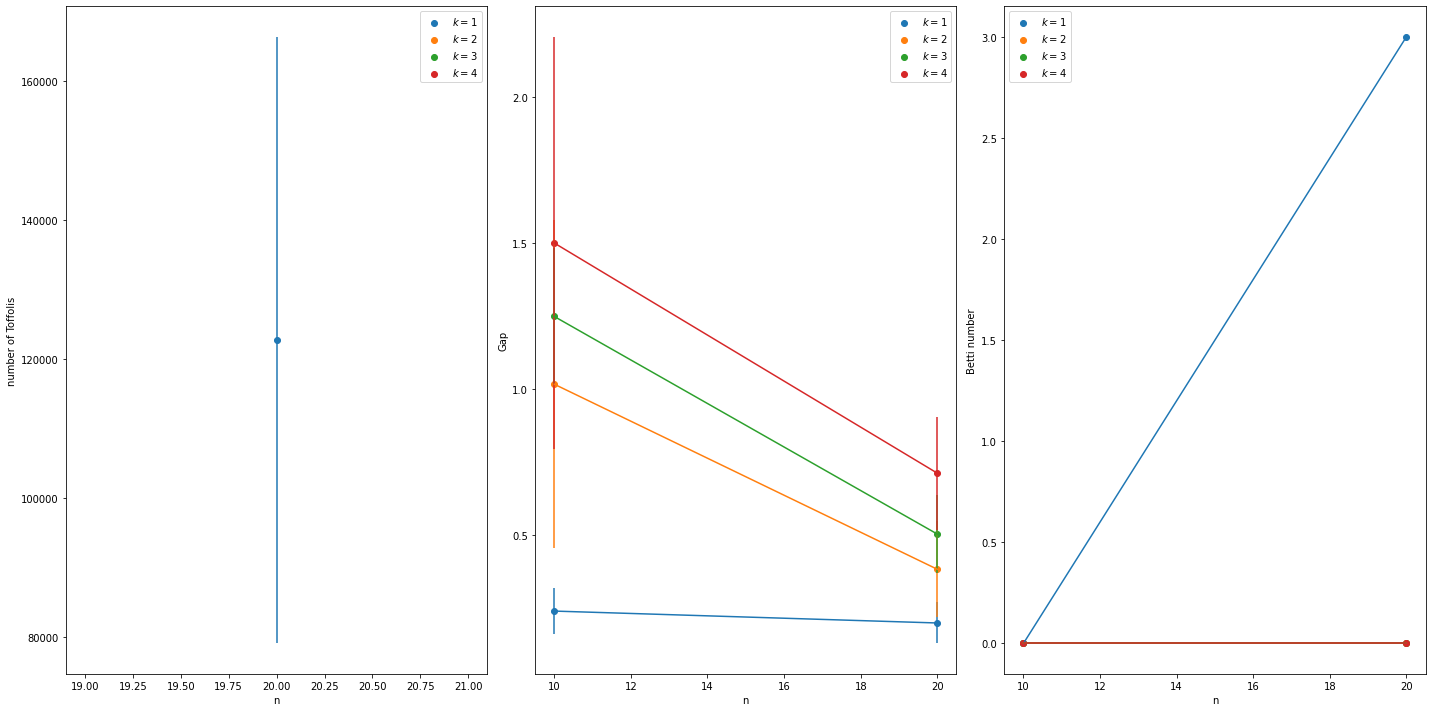

In [ ]:
#generate_data([10,20,30,35,40,45,50,55,60,65,70,75,80], [1,2,3,4,5], 10, 'ER', '')
generate_data([10,20], [1,2,3,4], 2, 'ER', '')
generate_plots([1,2,3,4], 'ER', '')

In [ ]:
a = np.load('_ER_bettis.npy', allow_pickle=True)
a

array([list([[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]),
       list([[1, 1, 1], [8, 8, 8], [27, 27, 27], [64, 64, 64], [125, 125, 125], [216, 216, 216], [343, 343, 343], [512, 512, 512], [729, 729, 729], [1000, 1000, 1000]]),
       list([]), list([])], dtype=object)

In [ ]:
plt.savefig('_ER_bettis.pdf')

###### *(2) Run lattice analysis*

(k, n, sample) = (1, 3, 1)
(k, n, sample) = (1, 3, 2)
(k, n, sample) = (1, 3, 3)
(k, n, sample) = (1, 3, 4)
(k, n, sample) = (1, 3, 5)
(k, n, sample) = (1, 3, 6)
(k, n, sample) = (1, 3, 7)
(k, n, sample) = (1, 3, 8)
(k, n, sample) = (1, 3, 9)
(k, n, sample) = (1, 3, 10)
(k, n, sample) = (1, 4, 1)
(k, n, sample) = (1, 4, 2)


<ipython-input-7-c935167b3843>:14: RuntimeWarning: divide by zero encountered in double_scalars
  return n * E * np.sqrt(comb(n, k) / betti_k_minus_one) / (r * gap)


(k, n, sample) = (1, 4, 3)
(k, n, sample) = (1, 4, 4)
(k, n, sample) = (1, 4, 5)
(k, n, sample) = (1, 4, 6)
(k, n, sample) = (1, 4, 7)
(k, n, sample) = (1, 4, 8)
(k, n, sample) = (1, 4, 9)
(k, n, sample) = (1, 4, 10)
(k, n, sample) = (1, 5, 1)
(k, n, sample) = (1, 5, 2)
(k, n, sample) = (1, 5, 3)
(k, n, sample) = (1, 5, 4)
(k, n, sample) = (1, 5, 5)
(k, n, sample) = (1, 5, 6)
(k, n, sample) = (1, 5, 7)
(k, n, sample) = (1, 5, 8)
(k, n, sample) = (1, 5, 9)
(k, n, sample) = (1, 5, 10)
(k, n, sample) = (1, 6, 1)
(k, n, sample) = (1, 6, 2)
(k, n, sample) = (1, 6, 3)
(k, n, sample) = (1, 6, 4)
(k, n, sample) = (1, 6, 6)
(k, n, sample) = (1, 6, 7)
(k, n, sample) = (1, 6, 8)
(k, n, sample) = (1, 6, 9)
(k, n, sample) = (1, 6, 10)
(k, n, sample) = (2, 3, 1)
(k, n, sample) = (2, 3, 2)
(k, n, sample) = (2, 3, 3)
(k, n, sample) = (2, 3, 4)
(k, n, sample) = (2, 3, 5)
(k, n, sample) = (2, 3, 6)
(k, n, sample) = (2, 3, 7)
(k, n, sample) = (2, 3, 8)
(k, n, sample) = (2, 3, 9)
(k, n, sample) = (2, 3, 1

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
/usr/lib/python3.8/statistics.py:689: RuntimeWarning: invalid value encountered in double_scalars
  T, total, count = _sum((x-c)**2 for x in data)
/usr/lib/python3.8/statistics.py:692: RuntimeWarning: invalid value encountered in double_scalars
  U, total2, count2 = _sum((x-c) for x in data)


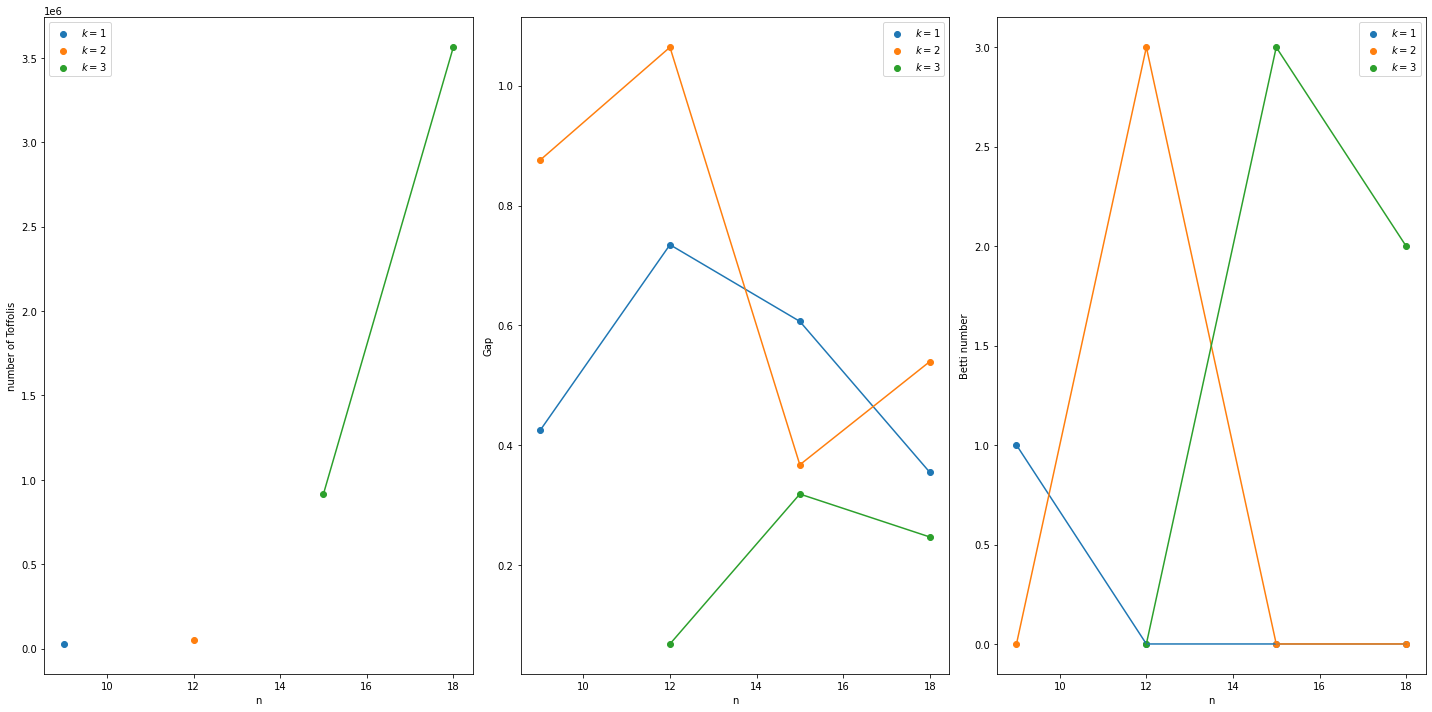

In [ ]:
#generate_data([10,20,30,35,40,45,50,55,60,65,70,75,80], [1,2,3,4,5], 10, 'ER', '')
#generate_data([1,2,3,4], [1,2,3], 10, 'financial', '')
#generate_data([[2,3],[3,3],[4,3]], [1,2,3,4,5], 10, 'kmk', '')

generate_data([3,4,5,6], [1,2,3], 10, 'lattice', '')
generate_plots([1,2,3], 'lattice', '')

In [ ]:
generate_data([3,4,5,6,7,8,9], [1,2,3], 10, 'lattice', '')
generate_plots([1,2,3], 'lattice', '')

(k, n, sample) = (1, 3, 1)
(k, n, sample) = (1, 3, 2)
(k, n, sample) = (1, 3, 3)
(k, n, sample) = (1, 3, 4)
(k, n, sample) = (1, 3, 5)
(k, n, sample) = (1, 3, 6)
(k, n, sample) = (1, 3, 7)
(k, n, sample) = (1, 3, 8)
(k, n, sample) = (1, 3, 9)
(k, n, sample) = (1, 3, 10)
(k, n, sample) = (1, 4, 1)
(k, n, sample) = (1, 4, 2)


<ipython-input-7-c935167b3843>:14: RuntimeWarning: divide by zero encountered in double_scalars
  return n * E * np.sqrt(comb(n, k) / betti_k_minus_one) / (r * gap)


(k, n, sample) = (1, 4, 3)
(k, n, sample) = (1, 4, 4)
(k, n, sample) = (1, 4, 5)
(k, n, sample) = (1, 4, 6)
(k, n, sample) = (1, 4, 7)
(k, n, sample) = (1, 4, 8)
(k, n, sample) = (1, 4, 9)
(k, n, sample) = (1, 4, 10)
(k, n, sample) = (1, 5, 1)
(k, n, sample) = (1, 5, 2)
(k, n, sample) = (1, 5, 3)
(k, n, sample) = (1, 5, 4)
(k, n, sample) = (1, 5, 5)
(k, n, sample) = (1, 5, 6)
(k, n, sample) = (1, 5, 7)
(k, n, sample) = (1, 5, 8)
(k, n, sample) = (1, 5, 9)
(k, n, sample) = (1, 5, 10)
(k, n, sample) = (1, 6, 1)
(k, n, sample) = (1, 6, 2)
(k, n, sample) = (1, 6, 3)
(k, n, sample) = (1, 6, 4)
(k, n, sample) = (1, 6, 5)
(k, n, sample) = (1, 6, 6)
(k, n, sample) = (1, 6, 7)
(k, n, sample) = (1, 6, 8)
(k, n, sample) = (1, 6, 9)
(k, n, sample) = (1, 6, 10)
(k, n, sample) = (1, 7, 1)
(k, n, sample) = (1, 7, 2)
(k, n, sample) = (1, 7, 3)
(k, n, sample) = (1, 7, 4)
(k, n, sample) = (1, 7, 5)
(k, n, sample) = (1, 7, 6)
(k, n, sample) = (1, 7, 7)
(k, n, sample) = (1, 7, 8)
(k, n, sample) = (1, 7, 9

KeyboardInterrupt: ignored

###### *(3) Run financial analysis*

(k, n, sample) = (1, 1, 1)
(k, n, sample) = (1, 1, 1)
(k, n, sample) = (1, 1, 1)
(k, n, sample) = (1, 1, 1)
(k, n, sample) = (1, 1, 1)
(k, n, sample) = (1, 1, 1)
Skipped n
(k, n, sample) = (1, 2, 1)
(k, n, sample) = (1, 2, 1)
(k, n, sample) = (1, 2, 1)
(k, n, sample) = (1, 2, 1)
(k, n, sample) = (1, 2, 1)
(k, n, sample) = (1, 2, 1)
Skipped n
(k, n, sample) = (2, 1, 1)
(k, n, sample) = (2, 1, 1)
(k, n, sample) = (2, 1, 1)
(k, n, sample) = (2, 1, 1)
(k, n, sample) = (2, 1, 1)
(k, n, sample) = (2, 1, 1)
Skipped n
(k, n, sample) = (2, 2, 1)
(k, n, sample) = (2, 2, 1)
(k, n, sample) = (2, 2, 1)
(k, n, sample) = (2, 2, 1)
(k, n, sample) = (2, 2, 1)
(k, n, sample) = (2, 2, 1)
Skipped n


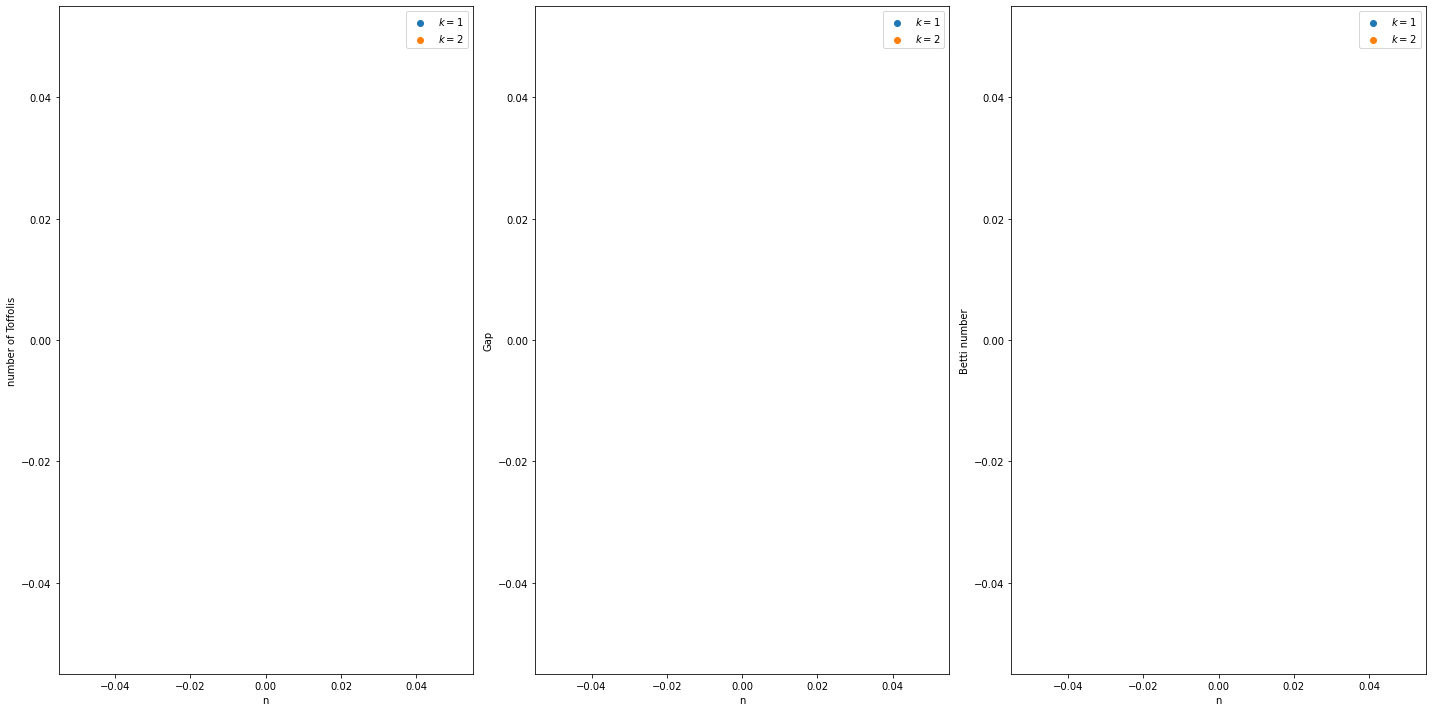

In [ ]:
#generate_data([10,20,30,35,40,45,50,55,60,65,70,75,80], [1,2,3,4,5], 10, 'ER', '')
#generate_data([3,4,5,6,7,8,9], [1,2,3], 10, 'lattice', '')
#generate_data([[2,3],[3,3],[4,3]], [1,2,3,4,5], 10, 'kmk', '')

generate_data([1,2], [1,2], 10, 'financial', '')
generate_plots([1,2], 'financial', '')

#### <font color="blue">***Optimization and Topological Data Analysis***

https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-optimization.ipynb

##### Optimization and Topological Data Analysis

Mathieu Carrière, https://mathieucarriere.github.io/website/

In this notebook, we are going to see how to combine Gudhi and Tensorflow in order to do persistence optimization!

In [ ]:
import numpy                 as np
import tensorflow            as tf
import matplotlib.pyplot     as plt
import pandas                as pd
import gudhi                 as gd
from tqdm                    import tqdm
from gudhi.tensorflow        import LowerStarSimplexTreeLayer, CubicalLayer, RipsLayer

##### Point cloud

You might have already seen a few examples of persistence diagram computations on point clouds. Among the different possibilities, the Rips filtration is the most common option due to its simplicity and easy implementation. In this section, we will see how Gudhi and Tensorflow can be combined to perform optimization of Vietoris-Rips persistence diagrams.

Let's have a quick refresher ;-)

First, let's generate a random point cloud in the unit square and visualize it.

In this section, we implement the point cloud experiment, where we optimize loops in a point cloud using 1-dimensional homology.

In [ ]:
np.random.seed(1)
Xinit = np.array(np.random.uniform(high=1., low=-1., size=(300,2)), dtype=np.float32)

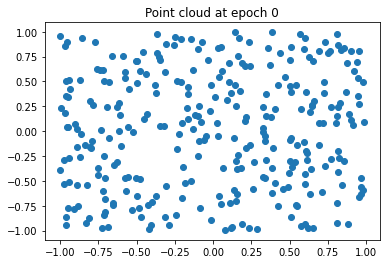

In [ ]:
plt.figure()
plt.scatter(Xinit[:,0], Xinit[:,1])
plt.title('Point cloud at epoch 0')
plt.show()

Yep, looks pretty random indeed. Let's now compute its Rips persistence diagram. This is literally two lines of code with Gudhi :-)

In [ ]:
st = gd.RipsComplex(points=Xinit, max_edge_length=1.).create_simplex_tree(max_dimension=2)
dgm = st.persistence()

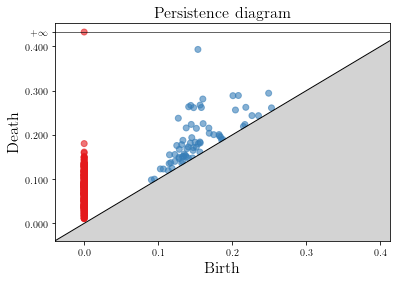

In [ ]:
plot = gd.plot_persistence_diagram(dgm)

As usual, there is one point (in dimension 0) at $+\infty$ which represents the whole connected component, a bunch of points in dimension 0 with abscissa 0 (actually, as many as there are points in the initial point cloud), and some points in dimension 1. There is nothing else because we only kept the 2-skeleton of the Rips complex in the previous cell.

This is great. But have you ever thought about the inverse problem? That is, can you tweak the point cloud so that the corresponding persistence diagram satisfies some properties? That sounds hard. Turns out it is not if you combine Gudhi and Tensorflow ;-)

Before jumping to the code, let's think about what's happening here. If you think about how persistence is computed, the coordinates of any point $p$ in a persistence diagram are actually given by the filtration values of two very specific simplices: the so-called positive and negative simplices of $p$, denoted by $\sigma_+(p)$ and $\sigma_-(p)$ (check chapter VII.1 in [this reference book](https://books.google.com/books/about/Computational_Topology.html?id=MDXa6gFRZuIC) for more details if you feel lost). So, we have: $$p=(f(\sigma_+(p)), f(\sigma_-(p))),$$
where $f$ is the filtration function. This means that if $f$ is actually defined by some parameters $f = f_\theta$, then the gradient $\nabla_\theta p$ is actually given by $\nabla_\theta f_\theta(\sigma_+(p))$ and $\nabla_\theta f_\theta(\sigma_-(p))$.

Interesting, but how does this look like for the Rips filtration? Well, first, the parameters $\theta$ are now the positions of the points in the point cloud. Second, as you may recall, the filtration value of any simplex is simply the maximal distance between any two vertices in the simplex: $f(\{v_0,\cdots, v_n\})=\|v_a-v_b\|$, $0\leq a,b\leq n$, where $\|v_a-v_b\|\geq \|v_i-v_j\|$, $\forall 0\leq i,j \leq n$. This has two consequences. First, this means that one can create the persistence diagram by simply picking entries of the distance matrix between the points. Second, this also means that the gradient of $f$ only depends on the positions of $v_a$ and $v_b$: $\nabla f=\frac{v_a-v_b}{\|v_a-v_b\|}$. You can check [this article](http://proceedings.mlr.press/v139/carriere21a/carriere21a.pdf) for more details.

All right! So the only thing that remains to do is to compute the positive and negative simplices, right? Turns out that Gudhi can do that with the TensorFlow layer called `RipsLayer`!

In [ ]:
X = tf.Variable(initial_value=Xinit, trainable=True)
layer = RipsLayer(maximum_edge_length=1., homology_dimensions=[1])

Next, we define a learning rate and an optimizer.

In [ ]:
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.)

Finally, we can optimize! We will maximize the distances to the diagonal of the persistence diagram points, so that loops are as large as possible. We also add a penalty that forces the points to stay in the unit square, to avoid artificially inflating a few loops and leaving the others unchanged. Running 1,000 epochs is a bit long, you might want to get a cup of coffee at this point.

In [ ]:
losses, dgms = [], []
for epoch in tqdm(range(200+1)):

    with tf.GradientTape() as tape:
        dgm = layer.call(X)[0][0]
        # Opposite of the squared distances to the diagonal
        persistence_loss = -tf.math.reduce_sum(tf.square(.5*(dgm[:,1]-dgm[:,0])))
        # Unit square regularization
        regularization = tf.reduce_sum(tf.maximum(tf.abs(X)-1, 0))
        loss = persistence_loss + regularization
    gradients = tape.gradient(loss, [X])

    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)

    optimizer.apply_gradients(zip(gradients, [X]))
    losses.append(loss.numpy())
    dgms.append(dgm)

100%|██████████| 201/201 [01:00<00:00,  3.32it/s]


Let's have a look at the results.

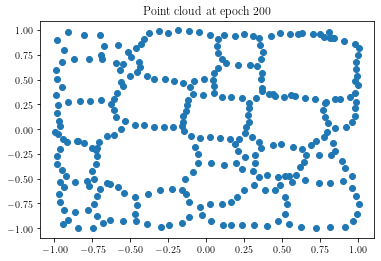

In [ ]:
plt.figure()
plt.scatter(X.numpy()[:,0], X.numpy()[:,1])
plt.title('Point cloud at epoch ' + str(epoch))
plt.show()

Looks like there are more cycles indeed ;-)

Let's also visualize the loss and the sequence of iterates.

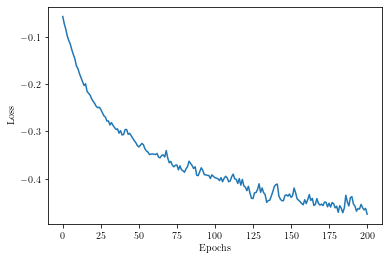

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

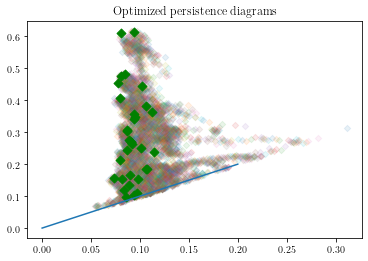

In [ ]:
plt.figure()
for dg in dgms[:5:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='green')
plt.plot([-0.,.2], [-0.,.2])
plt.title('Optimized persistence diagrams')
plt.show()

##### Image

We can actually play the same game with images! Indeed, Gudhi contains code for computing [cubical persistence](http://www2.im.uj.edu.pl/mpd/publications/Wagner_persistence.pdf), which is very well-suited for handling images. For instance, it can be used to filter a 2D image with its pixel values. Overall, the optimization follows the exact same steps as before, except that we use pixel filtration instead of Rips filtration. This means that the parameters $\theta$ that we are now going to optimize are the pixel values themselves, and that the gradients for positive simplex $\nabla_\theta f_\theta(\sigma_+(p))$ and negative simplex $\nabla_\theta f_\theta(\sigma_-(p))$ now simply equal $1$ for the pixels associated to $\sigma_+(p)$ and $\sigma_-(p)$ and $0$ for all other pixels. All of that is implemented in `CubicalLayer`.

We are going to use the following image:

In [ ]:
I = np.array(pd.read_csv('datasets/mnist_test.csv', header=None, sep=','), dtype=np.float32)
idx = np.argwhere(I[:,0] == 8)
image = np.reshape(-I[idx[8],1:], [28,28])
image = (image-image.min())/(image.max()-image.min())
image_clean = np.array(image)
image[2:5,2:5]        -= 0.4
image[25:27,25:27]    -= 0.4
image[25:27,2:5]      -= 0.4
image[1:4,24:26]      -= 0.4
image = image[:,1:]

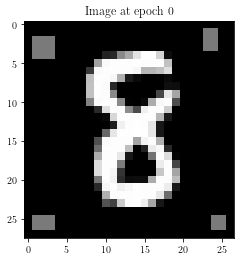

In [ ]:
plt.figure()
plt.imshow(image, cmap='Greys')
plt.title('Image at epoch 0')
plt.show()

As you can see, the image contains four stains. Since those stains correspond to connected components, we can detect them with 0-dimensional persistent homology, and try to remove them by optimizing the pixel values so that the points in the 0-dimensional persistence diagram have minimal distances to the diagonal. Also, as in the previous section,
we add a regularization term that forces the pixel values to be either 0 or 1.

In [ ]:
X = tf.Variable(initial_value=np.array(image, dtype=np.float32), trainable=True)
layer = CubicalLayer(homology_dimensions=[0])

In [ ]:
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-3, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

In [ ]:
losses, dgms = [], []
for epoch in range(500+1):
    with tf.GradientTape() as tape:
        dgm = layer.call(X)[0][0]
        # Squared distances to the diagonal
        persistence_loss = 10*tf.math.reduce_sum(tf.abs(dgm[:,1]-dgm[:,0]))
        # 0-1 regularization for the pixels
        regularization = tf.math.reduce_sum(tf.math.minimum(tf.abs(X),tf.abs(1-X)))
        loss = persistence_loss + regularization
    gradients = tape.gradient(loss, [X])

    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)

    optimizer.apply_gradients(zip(gradients, [X]))
    losses.append(loss.numpy())
    dgms.append(dgm)

Let's visualize the result!

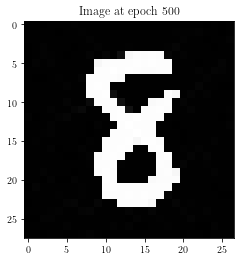

In [ ]:
plt.figure()
plt.imshow(X.numpy(), cmap='Greys')
plt.title('Image at epoch ' + str(epoch))
plt.show()

Yay! The stains have been removed!

As always, let's check convergence and have a look at the iterates.

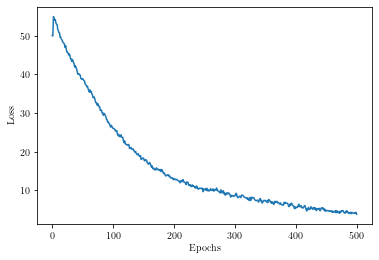

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

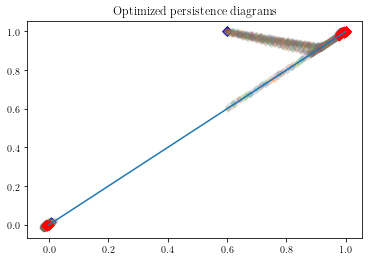

In [ ]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([0,1], [0,1])
plt.title('Optimized persistence diagrams')
plt.show()

##### Regression

Finally, Gudhi can also optimize the persistence diagram of a simplicial complex filtered by the lower-star filtration induced by its vertices. Pretty much like for images, the parameters $\theta$ that we are now going to optimize are the vertex values themselves, and the gradients associated to the point $p=(f_\theta(\sigma_+(p)), f_\theta(\sigma_-(p)))$ is simply 1 on all vertices that are part of $\sigma_+(p)$ and $\sigma_-(p)$ and $0$ for all other vertices. All of that is implemented in `LowerStarSimplexTreeLayer`.

We are going to illustrate this on a regression task $Y=X\cdot\beta^*+\epsilon$, where $X\in {\mathbb R}^{n\times p}$, $Y\in {\mathbb R}^{n}$, $\beta^*\in {\mathbb R}^{p}$ and $\epsilon$ is a small random noise. Moreover, the unknown coefficients $\beta^*$ have a specific shape, that we assume is known as a prior.

In [ ]:
np.random.seed(0)
n, p = 50, 100
betastar = np.concatenate([np.linspace(-1.,1.,33) for _ in range(3)] + [[-1.]])

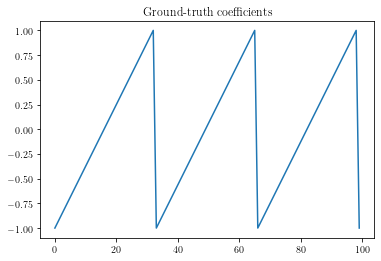

In [ ]:
plt.figure()
plt.plot(betastar)
plt.title('Ground-truth coefficients')
plt.show()

Indeed, when we plot the coefficients, the line they form has three peaks, that can be detected with 0-dimensional persistent homology. Our task will be to find $\beta^*$, knowing that its 0-dimensional persistence diagram should have three points.

Let's first generate the data.

In [ ]:
X = np.array(np.random.multivariate_normal(mean=np.zeros(shape=[p]), cov=np.eye(p), size=n), dtype=np.float32)
Y = np.array(np.matmul(X, betastar) + .05 * np.random.randn(n), dtype=np.float32)

We also store the line formed by the coefficients in a simplex tree.

In [ ]:
stbase = gd.SimplexTree()
for i in range(p-1):
    stbase.insert([i,i+1], -1e10)

Here's our initial (random) guess for $\beta^*$.

In [ ]:
betainit = np.random.uniform(low=-1., high=1., size=[p])
betainit[np.array([25,60,99])] = np.array([-1,-1,-1])

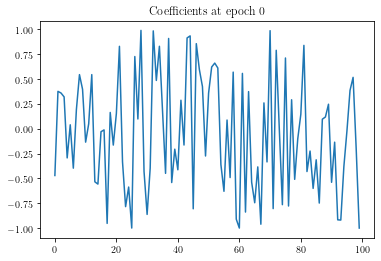

In [ ]:
plt.figure()
plt.plot(betainit)
plt.title('Coefficients at epoch 0')
plt.show()

For the sake of comparison, we will optimize the coefficients with different losses: using no regularization, using total variation, and using total variation and 0-dimensional persistent homology (i.e., forcing the 0-dimensional persistence diagram to have only three points).

Let's first optimize the initial coefficients without any penalty.

In [ ]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses, betas = [], []
for epoch in range(100+1):
    with tf.GradientTape() as tape:
        loss = 2 * tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y))
    gradients = tape.gradient(loss, [beta])

    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)

    optimizer.apply_gradients(zip(gradients, [beta]))
    losses.append(loss.numpy())
    betas.append(beta.numpy()[:,0])

beta_std = -betas[-1]

Now, let's try with total variation.

In [ ]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses, betas = [], []
for epoch in range(100+1):
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) \
             + 1e3 * tf.reduce_sum(tf.abs(beta[1:]-beta[:-1]))
    gradients = tape.gradient(loss, [beta])

    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)

    optimizer.apply_gradients(zip(gradients, [beta]))
    losses.append(loss.numpy())
    betas.append(beta.numpy()[:,0])

beta_stdtot = -betas[-1]

Finally, let's also add a topological regularization with `LowerStarSimplexTreeLayer`.

In [ ]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
layer = LowerStarSimplexTreeLayer(simplextree=stbase, homology_dimensions=[0])
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses, dgms, betas = [], [], []
for epoch in range(100+1):
    with tf.GradientTape() as tape:
        dgm = layer.call(beta)[0][0]
        # Minimize all points except the three most persistent ones
        top3 = np.argsort(dgm[:,1]-dgm[:,0]).ravel()[::-1][3:]
        loss =  tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) \
             + 1e4 * tf.reduce_sum(tf.abs(tf.gather_nd(dgm[:,1]-dgm[:,0], [[idx] for idx in top3]))) \
             + 1e3 * tf.reduce_sum(tf.abs(beta[1:]-beta[:-1]))
    gradients = tape.gradient(loss, [beta])

    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)

    optimizer.apply_gradients(zip(gradients, [beta]))
    losses.append(loss.numpy())
    dgms.append(dgm)
    betas.append(beta.numpy()[:,0])

beta_stdtop = -betas[-1]

Let's compare the results!

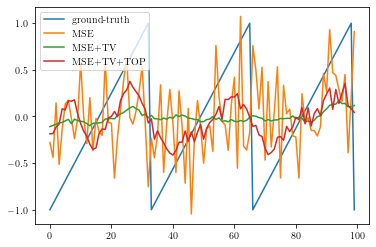

In [ ]:
plt.figure()
plt.plot(betastar, label='ground-truth')
plt.plot(beta_std, label='MSE')
plt.plot(beta_stdtot, label='MSE+TV')
plt.plot(beta_stdtop, label='MSE+TV+TOP')
plt.legend(loc='upper left')
plt.show()

Using all penalties is the best: while mean square error (MSE) looks pretty random and total variation (TV) shrinks the coefficients too much,
    topology (TOP) achieves the best compromise. This can be further validated by computing the MSE on new test sets: in average, the MSE of the coefficients optimized with topology is lower than the others.

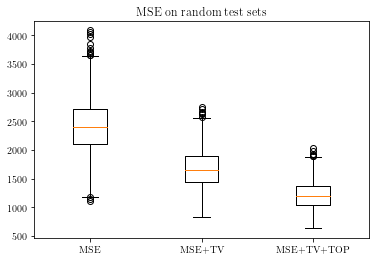

In [ ]:
MSEstd, MSEtop, MSEtot = [], [], []
for s in range(1000):
    np.random.seed(s)
    Xnew = np.random.multivariate_normal(mean=np.zeros(shape=[p]), cov=np.eye(p), size=n)
    Ynew = np.matmul(Xnew, betastar)
    mse_std = np.square(np.matmul(Xnew, beta_std) - Ynew).sum()
    mse_tot = np.square(np.matmul(Xnew, beta_stdtot) - Ynew).sum()
    mse_top = np.square(np.matmul(Xnew, beta_stdtop) - Ynew).sum()
    MSEstd.append(mse_std)
    MSEtot.append(mse_tot)
    MSEtop.append(mse_top)

plt.figure()
plt.boxplot([MSEstd, MSEtot, MSEtop], labels=['MSE', 'MSE+TV', 'MSE+TV+TOP'])
plt.title('MSE on random test sets')
plt.show()

Finally, we can have again a look at the convergence and iterates.

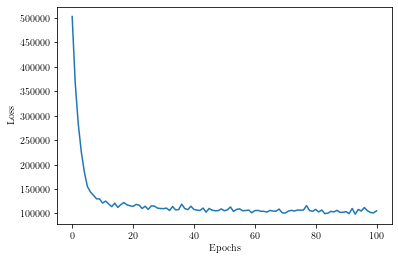

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

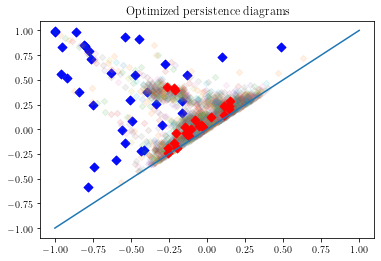

In [ ]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([-1,1], [-1,1])
plt.title('Optimized persistence diagrams')
plt.show()